In [1]:
import sys
sys.path.insert(0, "/arc/home/michilli/.local/lib/python3.8/site-packages/")
sys.path.append("/arc/home/michilli/CHIMEFRB-Cat1-Energy-Dist-Distrs/")

In [31]:
# CHIME
SNr_min = 12
chime_z_dist = run_simulation(
    int(1e6),
    telescope_name = 'chime',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

z_K, p_K = np.loadtxt('P_obs(z).dat', skiprows=4).T

y_hist, bins = np.histogram(chime_z_dist, bins=100, density=True)
plt.stairs(gf(y_hist, 6), bins, label='CHIME')

plt.plot(z_K, p_K, 'r--')

NameError: name 'run_simulation' is not defined

In [77]:
# Python 3.8.16
import os
import pickle
import datetime
import itertools

# Numpy 1.24.2
import numpy as np
from numpy.random import default_rng
# matplotlib 3.7.1
import matplotlib.pyplot as plt
# astropy 5.2.1
from astropy import units as u
from astropy.coordinates import Distance
from astropy import constants as const
from astropy.cosmology import Planck18 as cosmo
# scipy 1.9.3
from scipy.special import j1
from scipy import optimize
from scipy.stats import truncnorm
from scipy.ndimage import gaussian_filter as gf
from scipy.interpolate import CubicSpline as spline
from scipy import integrate
from scipy.interpolate import RegularGridInterpolator
from scipy.spatial import KDTree
from scipy.interpolate import interp1d
# mpmath 1.3.0
from mpmath import gammainc
# pandas 2.0.0
import pandas as pd


# Classes and functions

class Telescope:
    """
    Telescope parameters
    """
    parameters = {
        'dummy': {  # test parameters
            'Srec': 50 / 1.38 * u.Jy,
            'gain': 1.38 * u.K / u.Jy,
            'v0': 400 * u.MHz,
            'v1': 800 * u.MHz,            
            'Dx': 20 * u.m,
            'Dy': 0.5 * u.m,
        },
        'chime': {  # from https://ui.adsabs.harvard.edu/abs/2022ApJS..261...29C/abstract
            # from https://ui.adsabs.harvard.edu/abs/2017ApJ...844..140C/abstract
            'Srec': 50 / 1.38 * u.Jy,
            'gain': 1.38 * u.K / u.Jy,
            'v0': 400 * u.MHz,
            'v1': 800 * u.MHz,            
            'Dx': 20 * u.m,
            'Dy': 0.87 * u.m,  # Emprirical value to have a beam of ~100 deg
        },
        'burstt-2048': {  # from https://ui.adsabs.harvard.edu/abs/2022ApJS..261...29C/abstract
            # from https://ui.adsabs.harvard.edu/abs/2017ApJ...844..140C/abstract
            'Srec': 600 * u.Jy,
            'gain': 150 / 600 * u.K / u.Jy,
            'v0': 300 * u.MHz,
            'v1': 800 * u.MHz,
            'Dx': 0.87 * u.m,  # Emprirical value to have a beam of ~100 deg
            'Dy': 0.87 * u.m,  # Emprirical value to have a beam of ~100 deg
        },
        'utmost': {  # from https://arxiv.org/pdf/1708.09619.pdf
            'Srec': 115 * np.sqrt(2) * u.Jy,  # The sqrt(2) correction is for the single polarization
            'gain': 0.5 * u.K / u.Jy,
            'v0': 836 * u.MHz,
            'v1': 850 * u.MHz,            
            'Dx': 11.6 * u.m,
            'Dy': (
                0.88 * (835 * u.MHz).to(u.m, equivalencies=u.spectral()) / 
                (4.25 * u.deg).to(u.rad).value
            ),  # Value to have a FWHP=4.25deg
        },
        'chord': {  # from https://ui.adsabs.harvard.edu/abs/2019clrp.2020...28V/abstract
            'Srec': 9 * u.Jy,
            'gain': 30 / 9 * u.K / u.Jy,
            'v0': 300 * u.MHz,
            'v1': 1500 * u.MHz,
            'D': 6 * u.m,
            'bands': [
                [300 * u.MHz, 700 * u.MHz],
                [700 * u.MHz, 1100 * u.MHz],
                [1100 * u.MHz, 1500 * u.MHz],
            ]
        },
        'argos': {  # from https://drive.google.com/drive/folders/1-rWX86hCCb0r8m7yuI9Ubz3L5OE9st5AuGt5OO5QIoKmtPRx8rjzWJjplrMYzOnV64XuXWdb
            'Srec': 3.6 * u.Jy,
            'gain': 30 / 3.6 * u.K / u.Jy,
            'v0': 1000 * u.MHz,
            'v1': 3000 * u.MHz,
            'D': 6 * u.m,
        },
        'dsa2000': {  # from https://ui.adsabs.harvard.edu/abs/2019BAAS...51g.255H/abstract
            'Srec': 2.5 * u.Jy,
            'gain': 25 / 2.5 * u.K / u.Jy,
            'v0': 700 * u.MHz,
            'v1': 2000 * u.MHz,
            'D': 5 * u.m,
            'bands': [
                [700 * u.MHz, 1100 * u.MHz],
                [1100 * u.MHz, 1500 * u.MHz],
                [1500 * u.MHz, 2000 * u.MHz],
            ]
        },
        'aperitif': {  # from https://ui.adsabs.harvard.edu/abs/2022A%26A...658A.146V/abstract
            'Srec': 560 * u.Jy,
            'gain': 70 / 560 * u.K / u.Jy,
            'v0': (1370 - 300/2) * u.MHz,
            'v1': (1370 + 300/2) * u.MHz,            
            'D': 25 * u.m,
        },
        'fast': {  # from https://ui.adsabs.harvard.edu/abs/2016RaSc...51.1060L/abstract
            'Srec': 20 * u.K / (18 * u.K / u.Jy),
            'gain': 18 * u.K / u.Jy,
            'v0': 1220 * u.MHz,
            'v1': 1520 * u.MHz,            
            'D': 300 * u.m,
        },
        'askap': {  # from https://ui.adsabs.harvard.edu/abs/2016PASA...33...42M/abstract
            'Srec': 2000 * u.Jy,
            'gain': 115 / 4000 * u.K / u.Jy,
            'v0': (1320 - 336/2) * u.MHz,
            'v1': (1320 + 336/2) * u.MHz,            
            'D': 12 * u.m,
        },
        'parkes': {  # from https://ui.adsabs.harvard.edu/abs/2001MNRAS.328...17M/abstract
            'Srec': 21 / 0.7 * u.Jy,
            'gain': 0.7 * u.K / u.Jy,
            'v0': (1374 - 288/2) * u.MHz,
            'v1': (1374 + 288/2) * u.MHz,            
            'D': 64 * u.m,
        },
        'parkes': {  # from https://ui.adsabs.harvard.edu/abs/2001MNRAS.328...17M/abstract
            'Srec': 21 / 0.7 * u.Jy,
            'gain': 0.7 * u.K / u.Jy,
            'v0': (1374 - 288/2) * u.MHz,
            'v1': (1374 + 288/2) * u.MHz,            
            'D': 64 * u.m,
        },
        'gbt': {  # from https://www.gb.nrao.edu/scienceDocs/GBTpg.pdf
            'Srec': 10 * u.Jy,
            'gain': 2 * u.K / u.Jy,
            'v0': 1150 * u.MHz,
            'v1': 1730 * u.MHz,            
            'D': 100 * u.m,
        },
    }
    
    def __init__(self, name='chord'):
        self.name = name
        self.parameters = Telescope.parameters
        try:
            _ = self.parameters[name]
        except KeyError:
            raise NotImplemented("Telescope unknown.")
        
    def get_parameters(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]
    
    def bandwidth(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]['v1'] - self.parameters[name]['v0']
    
    def sefd(self, name = None, freq = None, uncertain = False):
        if name is None: name = self.name
        if freq is None:
            freq = (
                self.parameters[name]['v0'] + 
                self.parameters[name]['v1']
            ) / 2
        sefd = (
            self.parameters[name]['Srec'] + 
            34 * u.K * (freq / 408 / u.MHz)**-2.6 / 
            self.parameters[name]['gain']
        )
        if uncertain:
            # Add an error of 20%
            sefd = rng.normal(
                loc=sefd.to(u.Jy).value,
                scale=sefd.to(u.Jy).value * 0.2
            ) * u.Jy
        return sefd
    
    def v0(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]['v0']
    
    def v1(self, name = None):
        if name is None: name = self.name
        return self.parameters[name]['v1']
    
    def frequency_bands(self, name = None):
        if name is None: name = self.name
        try:
            return self.parameters[name]['bands']
        except KeyError:
            return [[
                self.parameters[name]['v0'],
                self.parameters[name]['v1']
            ]]
    
    def get_parameter(self, parameter, name = None):
        if name is None: name = self.name
        return self.parameters[name][parameter]

    
class FRB_Population:
    """
    Parameters of the FRB population.
    """
    parameters = {
        'shin': {  # From https://ui.adsabs.harvard.edu/abs/2022arXiv220714316S/abstract
            'Echar': 2.38e41 * u.erg,  # Characteristic energy cut-of
            'alpha_spect': -1.39,  # Spectral index
            'alpha_rate': 0,  # Rate index
            'gamma': -1.3,  # Differential power-law index
            'Epivot': 1e39 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': 7.3e4 / u.Gpc**3 / u.year,  # FRB rate at z=0 above Epivot
            'n_sfr': 0.96,  # Index of star-formation rate
        },
        'shin_rate_interpretation': {  # From https://ui.adsabs.harvard.edu/abs/2022arXiv220714316S/abstract
            'Echar': 1.95e41 * u.erg,  # Characteristic energy cut-of
            'alpha_spect': 0,  # Spectral index
            'alpha_rate': -1.10,  # Spectral index
            'gamma': -1.3,  # Differential power-law index
            'Epivot': 1e39 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': 6.8e4 / u.Gpc**3 / u.year,  # FRB rate at z=0 above Epivot
            'n_sfr': 1.72,  # Index of star-formation rate
        },
        'james2023': {  # From https://arxiv.org/pdf/2208.00819.pdf
            'Echar': 10**41.26 * u.erg,  # Characteristic energy cut-of
            'alpha_spect': 0,  # Spectral index
            'alpha_rate': -0.99,  # Spectral index
            'gamma': -0.95-1,  # Differential power-law index
            'n_sfr': 1.13,  # Index of star-formation rate
            'Epivot': 1e30 * u.erg,  # Pivot energy
            'frb_emission_rate_z0_Epivot': (10**1.96/u.Mpc**3/u.day).to(1/u.Gpc**3/u.yr)
        },
    }
    
    def __init__(self, name='shin'):
        self.model = name
        self.parameters = FRB_Population.parameters
        try:
            _ = self.parameters[self.model]
        except KeyError:
            raise NotImplemented("Telescope unknown.")
        
    def get_parameters(self, model = None, uncertain = False):
        if model is None: 
            model = self.model
        parameters = dict(self.parameters[model])
        
        if uncertain:
            # Choose a random value in the parameter distributions
            if model != 'shin':
                raise NotImplementedError("Uncertainties currently available only for model 'shin'")

            if model == 'shin':
                parameters['frb_emission_rate_z0_Epivot'] = (
                    rng.choice(np.exp(samples_shin[:, 0])) / u.Gpc**3 / u.year
                )
                parameters['gamma'] = rng.choice(samples_shin[:, 1])
                parameters['Echar'] = rng.choice(np.exp(samples_shin[:, 2])) * u.erg
                parameters['n_sfr'] = rng.choice(samples_shin[:, 3])
                parameters['alpha_spect'] = rng.choice(samples_shin[:, 4])
        return parameters


def get_lensed_galaxy_fraction(
    zmin = None,
    zmax = None,
    frbs_evolve_with_luminosity = True,
):
    """ Fraction of lensed galaxies as a function of redshift from Collett 2015.
    """
    # Unlensed (org) and lensed (sim) galaxy populations used in Collett 2018 simulations
    # Redshift distributions
    z_org = np.loadtxt(data_unlensed_catalog, usecols=2, delimiter=',')
    z_sim = np.loadtxt(data_lensed_galaxies, usecols=1, skiprows=1)
    
    # Ensures that there are ~100 galaxies per step on average
    if zmin is None:
        zmin = max(z_org.min(), z_sim.min())
    if zmax is None:
        zmax = min(z_org.max(), z_sim.max())
    z = np.linspace(zmin, zmax, z_org.size//100+1)
    z_mean = (z[1:] + z[:-1]) / 2
    
    # Lensed and total galaxies per redshift bin
    Pz_sim, _ = np.histogram(z_sim, bins=z)
    Pz_org, _ = np.histogram(z_org, bins=z)
    
    # Select bins containing enough galaxies
    idx = (Pz_sim > 10) & (Pz_org > 10)
    Pz_sim = Pz_sim[idx]
    Pz_org = Pz_org[idx]
    z_mean = z_mean[idx]
    
    if frbs_evolve_with_luminosity:
        # Luminosity of unlensed population of galaxies used in Collett 2018 simulations
        M_org = np.loadtxt(data_unlensed_catalog, usecols=7, delimiter=',') * u.M_bol
        L_org = M_org.to(u.L_sun) * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Total luminosity of unlensed galaxy population per redshift step
        PL_org, _ = np.histogram(
            z_org, 
            bins=z, 
            weights=L_org
        )
        PL_org = PL_org[idx]
        # Luminosity of lensed galaxies used from Collett 2018 simulations
        Mv_sim = np.loadtxt(data_lensed_galaxies, usecols=15, skiprows=1) * u.M_bol # Magnitude distribution
        L_sim = Mv_sim.to(u.L_sun)
        # Total luminosity of lensed galaxy population per redshift step
        PL_sim, _ = np.histogram(
            z_sim, 
            bins=z, 
            weights=L_sim
        )
        PL_sim = PL_sim[idx]
        # Fraction of luminosity of lensed galaxies per redshift step
        lensed_fraction = PL_sim / PL_org

    else:
        Pz_org = Pz_org * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Fraction of lensed galaxies per redshift step
        lensed_fraction = Pz_sim / Pz_org
        
    # Smooth the output
    lensed_fraction = gf(lensed_fraction, 6)
    # Interpolate with a spline
    #lensed_fraction_iterp = spline(z_mean, lensed_fraction, extrapolate=False)
    lensed_fraction_iterp = np.poly1d(np.polyfit(z_mean, lensed_fraction, 2))
    return lensed_fraction_iterp


def get_unlensed_galaxy_distribution(
    zmin,
    zmax,
    frbs_evolve_with_luminosity = True,
):
    """ Distribution of unlensed galaxies as a function of redshift from Collett 2015.
    """
    # Unlensed population of galaxies used in Collett 2018 simulations
    z_org = np.loadtxt(data_unlensed_catalog, usecols=2, delimiter=',')
    
    # Ensures that there are ~100 galaxies per step on average
    z = np.linspace(zmin, zmax, z_org.size//100+1)
    z_mean = (z[1:] + z[:-1]) / 2
    
    # Total galaxies per redshift bin
    Pz_org, _ = np.histogram(z_org, bins=z)

    # Select bins containing enough galaxies
    idx = Pz_org > 10
    Pz_org = Pz_org[idx]
    z_mean = z_mean[idx]
    
    if frbs_evolve_with_luminosity:
        # Luminosity of unlensed population of galaxies used in Collett 2018 simulations
        M_org = np.loadtxt(data_unlensed_catalog, usecols=7, delimiter=',') * u.M_bol
        L_org = M_org.to(u.L_sun) * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        # Total luminosity of unlensed galaxy population per redshift step
        PL_org, _ = np.histogram(
            z_org, 
            bins=z, 
            weights=L_org
        )
        probability_norm = PL_org[idx]
    else:
        probability_norm = Pz_org * 10 * 360**2 / np.pi  # The population covers 0.1 square deg
        
    # Smooth the output
    unlensed_galaxy_dist = gf(probability_norm, 6)
    # Interpolate with a spline
    unlensed_galaxy_interp = spline(z_mean, unlensed_galaxy_dist, extrapolate=False)
    
    # Size of unlensed galaxy population
    z_min = z_mean.min()
    z_max = z_mean.max()
    return unlensed_galaxy_interp, z_min, z_max


def set_distribution_redshift(
    z_min,
    z_max,
    alpha_rate,
    frb_emission_rate_z0_Epivot,
    n_sfr
):
    """Set the parameters to sample a redshift distribution of a non-evolving population of FRBs.
    """
    # PDF of z distribution
    # Calculate the integrated normalization
    sfr = lambda z: (1 + z)**2.7 / (2.9**5.6 + (1 + z)**5.6)
    z_pdf = lambda z: (
        frb_emission_rate_z0_Epivot * 
        get_dv(z) * u.sr / 
        (1 + z)**(1-alpha_rate) * (sfr(z) / sfr(0))**n_sfr
    ).to(1 / u.yr).value
    frb_emission_rate = integrate.quad(z_pdf, z_min, z_max)[0]
    # Normalized distribution
    z_pdf_norm = lambda z: z_pdf(z) / frb_emission_rate

    # Find maximum of distribution with a spline and its derivative
    # Mock data
    z = np.linspace(z_min, z_max, 1000)
    P_z = z_pdf_norm(z)
    # Spline interpolation
    cs = spline(z, P_z)
    # Redshift of null derivatives
    roots = cs.derivative().roots()
    # Location of the maximum of the curve
    curve_max = z[P_z.argmax()]
    # Redshift of the null derivative closest to the location of the maximum
    x_max = roots[np.argmin(np.abs(roots - curve_max))]
    # Maximum of the distribution plus 1% to account for granularity
    y_max = z_pdf_norm(x_max)
    y_max = y_max + 0.01 * y_max
    return y_max, z_pdf_norm, frb_emission_rate / u.yr

    
def sample_distribution_redshift(
    number_of_simulated_frbs,
    z_min,
    z_max,
    y_max,
    z_pdf_norm,
):
    """Sample a redshift distribution of FRBs.
    """
    # Rejection sampling the distribution
    z_dist = np.zeros(number_of_simulated_frbs) + np.nan
    # Loop until no nan are present
    while np.isnan(z_dist).any():
        # Random values in a box around the function
        x = rng.uniform(low=z_min, high=z_max, size=number_of_simulated_frbs)
        y = rng.uniform(low=0, high=y_max, size=number_of_simulated_frbs)
        # Resize the arrays to get the right number of bins
        nan_size = z_dist[np.isnan(z_dist)].size
        x = x[y < z_pdf_norm(x)][:nan_size]
        first_nan = np.argmax(z_dist)
        z_dist[first_nan:first_nan+x.size] = x
    return z_dist


def get_distribution_dist(
    number_of_simulated_frbs,
    alpha_spect,
    alpha_rate,
    frb_emission_rate_z0_Epivot,
    n_sfr,
    simulate_lensed_frbs = True,
    z_min = None,
    z_max = None,
    lensed_fraction = None,
    frbs_evolve_with_luminosity = True,
):
    """Distribution of the distance factor.
    """
    # Catalog of lensed galaxies
    lensed_galaxies = pd.read_csv(
        data_lensed_galaxies,
        delim_whitespace=True
    )
    if z_max is None:
        z_max = lensed_galaxies['z_s'].max()
    if z_min is None:
        z_min = lensed_galaxies['z_s'].min()
    
    # Redshift distribution of unlensed galaxies used in Collett 2015
    if simulate_lensed_frbs:
        (unlensed_galaxy_interp,
            z_min,
            z_max
        )= get_unlensed_galaxy_distribution(
            z_min,
            z_max,
            frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
        )
        lensed_galaxies = lensed_galaxies[
            (lensed_galaxies['z_s'] >= z_min) &
            (lensed_galaxies['z_s'] <= z_max)
        ]
        
    # Redshift distribution of FRBs in the Universe
    y_max, z_pdf_norm, frb_emission_rate = set_distribution_redshift(
        z_min,
        z_max,
        alpha_rate,
        frb_emission_rate_z0_Epivot,
        n_sfr
    )
    if not simulate_lensed_frbs:
        # Redshift distribution of FRBs
        z_dist = sample_distribution_redshift(
            number_of_simulated_frbs,
            z_min,
            z_max,
            y_max,
            z_pdf_norm,
        )
        hosts = None
    else:
        # Redshift distribution of lensed FRB hosts
        if frbs_evolve_with_luminosity:
            # Luminosity fraction of each galaxy in its redshift bin
            lensed_galaxies_Mv = lensed_galaxies['M_absolute_source_r'].to_numpy() * u.M_bol
            p = (
                z_pdf_norm(lensed_galaxies['z_s'].to_numpy()) / 
                unlensed_galaxy_interp(lensed_galaxies['z_s']) * 
                lensed_galaxies_Mv.to(u.L_sun)
            )
        else:
            # Fraction of each galaxy in its redshift bin 
            p = (
                z_pdf_norm(lensed_galaxies['z_s']) / 
                unlensed_galaxy_interp(lensed_galaxies['z_s'])
            )
            
        # Table of host galaxies
        galaxy_index = rng.choice(
            np.arange(lensed_galaxies['z_s'].size, dtype=int),
            p = p / p.sum(),
            size = number_of_simulated_frbs
        )
        hosts = lensed_galaxies.iloc[galaxy_index]
        hosts.reset_index(drop=True, inplace=True)
        
        # Redshift distribution of FRB hosts
        z_dist = hosts['z_s'].to_numpy()
    
    # Distance factor
    Dl = get_Dl(z_dist)
    dist_factor = (4 * np.pi * Dl**2) / (1 + z_dist)**(2+alpha_spect)
    return dist_factor, z_dist.min(), z_dist.max(), frb_emission_rate, hosts, z_dist


def get_bandwidth(
    number_of_simulated_frbs,
    bw_telescope,
    bw_min = 50 * u.MHz,
    loc = 400 * u.MHz,  # MHz
    scale = 400 / 2 * u.MHz,  # MHz
):
    """Assume that the bandwidth of FRBs is a normal distribution based on CHIME detections."""
    # Bandwidth distribution from a truncated normal distribution
    bw_clip = (bw_min - loc) / scale
    bw = truncnorm.rvs(
        bw_clip, 
        np.inf, 
        loc=loc, 
        scale=scale,
        size=number_of_simulated_frbs,
        random_state=rng
    ) * u.MHz
    return bw


def get_energy_minimum(
    bw,
    sefd,
    frb_bw,
    w,
    tau,
    dist_factor,
    frb_w_correction,
    frb_bw_correction,
):
    """
    Minimum FRB energy normalized to 1 GHz required to detect a burst at 
    redshift z with a signal-to-noise ratio SNr and time resolution w, 
    where rfi_band is lost due to interference.
    """
    return (
        SNr_min * np.sqrt((w + tau) / bw / 2) / frb_w_correction / frb_bw_correction * 
        sefd / np.sqrt(1 - rfi_band) * dist_factor * frb_bw
    ).min().to(u.erg)


def get_distribution_E(
    number_of_simulated_frbs,
    Emin,
    Echar,
    gamma,
):
    """Rejection sample a Schechter function describing the FRB energy distribution."""
    # Normalized Schechter distribution
    schechter_pdf = lambda E: (E / Echar)**gamma * np.exp(-E / Echar)
    # norm = float(gammainc(gamma+1, (Emin/Echar).to(u.dimensionless_unscaled).value)) * Echar
    norm = Emin * schechter_pdf(Emin)
    schechter_pdf_norm = lambda E: schechter_pdf(E) / norm
    # Rejection sampling the target Schechter distribution
    dist = np.zeros(number_of_simulated_frbs) * u.erg + np.nan
    # Loop until no nan are present
    while np.isnan(dist).any():
        nan_size = dist[np.isnan(dist)].size
        # Random variable from a proposal Pareto distribution
        if gamma <= -1:
            # The Pareto distribution is defined for the parameter a >= 0
            a = -gamma-1
            # Clip to avoid overflows
            x = (
                np.clip(
                    rng.pareto(a, size=number_of_simulated_frbs),
                    1e-200,
                    1e200
                ) + 1
            ) * Emin
        else:
            # Otherwise, use powerlaw distribution = 1 / (1 + Pareto)
            a = gamma+1
            x = (
                Emin / 
                np.clip(
                    rng.power(a, size=number_of_simulated_frbs),
                    1e-200,
                    1e200
                )
            )
        # PDF of proposal distribution at the random variable's values
        y_prop = (x/Emin)**gamma / Emin
        # Random sampling of the proposal distribution's PDF
        y_samp = rng.uniform(low=0, high=y_prop, size=number_of_simulated_frbs) / u.erg
        # Reject random variable's values where target distribution
        # is larger than the sampling values
        x = x[y_samp < schechter_pdf_norm(x)][:nan_size]
        # Resize the arrays to get the right number of bins
        first_nan = np.argmax(dist)
        dist[first_nan:first_nan+x.size] = x
    return dist


def get_beam_response(
    number_of_simulated_frbs,
    telescope,
    freq_min,
    min_frb_band = 50 * u.MHz,
    efficiency = 0.7
):
    # Minimum band to detect >50 MHz of a burst
    wavelength = (freq_min + min_frb_band).to(u.meter, equivalencies=u.spectral())
    # From "Tools of Radio Astronomy, by T.L. Wilson, K. Rohlfs, S. Huttemeister"
    try:
        # Circular aperture
        diameter = telescope.get_parameter('D')
        # Half beam width between the first nulls
        hwfn = (2.439 * u.rad * wavelength / diameter / 2).to(u.rad)
        # Random angles
        angle = rng.uniform(
            low=0,
            high=hwfn.to(u.rad).value**2,
            size=number_of_simulated_frbs
        )**0.5 * u.rad
        # Normalized power
        x = np.pi * np.sin(angle) * diameter / wavelength * np.sqrt(efficiency)
        power = (2 * j1(x) / x)**2
        # Simulated sky fraction
        sky_fraction = (hwfn**2 / 4 / u.steradian).value

    except KeyError:
        # Rectangular aperture
        size_x = telescope.get_parameter('Dx')
        size_y = telescope.get_parameter('Dy')
        # Half beam width between the first nulls
        hwfn_x = np.arcsin((wavelength / size_x).to(u.dimensionless_unscaled))
        hwfn_y = np.arcsin((wavelength / size_y).to(u.dimensionless_unscaled))
        # Random angles
        angle_x = rng.uniform(
            low=0, 
            high=hwfn_x.to(u.rad).value, 
            size=number_of_simulated_frbs
        ) * u.rad
        angle_y = rng.uniform(
            low=0, 
            high=hwfn_y.to(u.rad).value,
            size=number_of_simulated_frbs
        ) * u.rad
        # Normalized power
        power = (
            (
                np.sinc(np.sin(angle_x) * size_x / wavelength * u.rad) * 
                np.sinc(np.sin(angle_y) * size_y / wavelength * u.rad)
            )**2
        )
        # Simulated sky fraction
        sky_fraction = (hwfn_x * hwfn_y / 4 / np.pi / u.steradian).value
    return sky_fraction, power

    
def get_magnified_images(
    hosts,
    sie_org = None
):
    """Magnification factors based on simulations of point sources in lensed galaxies."""
    # Load simulation results
    if sie_org is None:
        sie_org = pd.read_csv(data_sie_catalog, index_col=['q', 0])
        sie_org.index.names = ['q','id']
        sie_org.sort_index(inplace=True)
    sie = sie_org.loc[np.sort(hosts['q_l'].clip(0.01, 0.99).unique())]
    sie.sort_index(inplace=True)
    
    # FRB distribution within the hosts
    frb_host_dist = (
        rng.exponential(size=hosts.shape[0]) *
        hosts['halflightradius_s(arcsec)'].to_numpy() *
        u.arcsec
    )
    frb_host_angle = rng.uniform(low=0, high=2*np.pi, size=hosts.shape[0]) * u.rad
    # FRB coordinates in the lens refenrence in units of Einstein radius
    frb_host_x = frb_host_dist * np.cos(frb_host_angle)
    frb_host_y = frb_host_dist * np.sin(frb_host_angle)
    frb_lens_x = frb_host_x + hosts['x_s_unlensed'].to_numpy() * u.arcsec
    frb_lens_y = frb_host_y + hosts['y_s_unlensed'].to_numpy() * u.arcsec
    frb_lens_x_Er = frb_lens_x / hosts['R_Ein(arcsec)'].to_numpy() / u.arcsec
    frb_lens_y_Er = frb_lens_y / hosts['R_Ein(arcsec)'].to_numpy() / u.arcsec
    frb_lens_dist_Er = np.hypot(frb_lens_x_Er, frb_lens_y_Er).value
    
    # Create a KD tree to find nearest point
    tree = KDTree(list(map(list, zip(*[
        sie.index.get_level_values(0).to_numpy(),
        np.hypot(sie['RA'], sie['DEC']).to_numpy()
    ]))))
    
    # Query KD tree for each host
    _, sie_idx = tree.query(list(map(list, zip(*[
        hosts['q_l'].to_numpy(),
        frb_lens_dist_Er
    ]))))
    
    return sie.iloc[sie_idx].sort_index()


def get_scattering_lens(
    hosts,
    sie
):
    # Impact parameter in the lens frame for each image for Reinstein=1
    impact_parameters = pd.DataFrame()
    for n in range(1, 5):
        impact_parameters[f'im{n}'] = (
            np.sqrt(
                np.sum(
                    sie[[f'im{n}_RA', f'im{n}_DEC']]**2,
                    axis=1
                )
            )  
        )
    # Rescale to Reinstein and Re
    impact_parameters = impact_parameters.multiply(
        (
            hosts['R_Ein(arcsec)'] /
            hosts['halflightradius_s(arcsec)']
        ).to_numpy(),
        axis=0
    )
    
    # Calculate lens galaxy masses from dispersion velocity
    # From https://arxiv.org/pdf/1208.3522.pdf, Eq. 21
    lens_mass = (
        2.5 * 
        (hosts['sigma(km/s)'].to_numpy() *u.km / u.s)**2 *
        (hosts['halflightradius_l(arcsec)'].to_numpy() *u.arcsec).to(u.rad).value *
        cosmo.angular_diameter_distance(hosts['z_l'].to_numpy()) / 
        const.G
    ).to(u.M_sun)
    
    # Calculate scattering at the impact parameters
    # Load scattering values
    lens_scattering = pd.read_csv(data_lens_scattering)
    # Create interpolator
    scattering_interp = RegularGridInterpolator(
        [
            lens_scattering['impact_param'],
            [1e9, 1e10, 1e11, 1e12],
        ],
        lens_scattering[[
            'tau_9Msun',
            'tau_10Msun',
            'tau_11Msun',
            'tau_12Msun',
        ]].to_numpy(),
        bounds_error = False,
        fill_value = None
    )
    # Points to evaluate    
    frb_lens_scattering = pd.DataFrame()
    for n in range(1, 5):
        frb_lens_scattering[f'im{n}'] = ((
            scattering_interp(
                np.vstack([
                    impact_parameters[f'im{n}'].to_numpy(),
                    lens_mass.value
                ]).T
            )  * u.ms / u.pc).to(u.ms / u.Mpc).value
        )
    frb_lens_scattering.clip(0, None, inplace=True)
    
    # Multiply by a factor (dls*dlo/dso)*(1+zl)^(-3) (Ocker+23)
    dls = cosmo.angular_diameter_distance_z1z2(
        hosts['z_l'].to_numpy(),
        hosts['z_s'].to_numpy()
    ).to(u.Mpc).value
    dlo = cosmo.angular_diameter_distance(hosts['z_l'].to_numpy()).to(u.Mpc).value
    dso = cosmo.angular_diameter_distance(hosts['z_s'].to_numpy()).to(u.Mpc).value
    zl = hosts['z_l'].to_numpy()
    frb_lens_scattering = frb_lens_scattering.multiply(
        dls * dlo / dso / (1 + zl)**3,
        axis=0
    )
    return frb_lens_scattering


def get_lensed_frb_detections(
    hosts,
    frb_snr,
    z_min,
    z_max,
    frb_E_nu,
    frb_dist_fact,
    frb_bw,
    frb_w,
    frb_tau,
    freq_mean,
    frbs_evolve_with_luminosity = True,
    sie = None
):
    # Magnification factors
    sie = get_magnified_images(
        hosts,
        sie_org = sie
    )
    hosts.reset_index(drop=True, inplace=True)
    mu = sie[["mu_1", "mu_2", "mu_3", "mu_4"]]
    mu.columns = [f"im{i}" for i in range(1,5)]

    # First pass to reduce the number of FRBs
    # S/N of the unlensed FRB detected in a follow-up observation
    snr_followup = get_snr(
        frb_E_nu,
        frb_dist_fact,
        frb_bw,
        frb_w,
        frb_tau,
        1,
        1,
        1, 
        Telescope(name=telescope_followup).sefd(), 
        rfi_band,
    )

    # FRBs with magnified S/N > SNr_min_followup in follow-up observations
    snr_images_followup = mu.multiply(snr_followup, axis=0)
    idx_images_followup = ((snr_images_followup > SNr_min_followup).sum(axis=1) > 1).to_numpy()
    hosts = hosts[idx_images_followup].reset_index(drop=True)
    sie = sie[idx_images_followup].reset_index(drop=True)
    mu = mu[idx_images_followup].reset_index(drop=True)
    frb_snr = frb_snr[idx_images_followup]
    frb_tau = frb_tau[idx_images_followup]

    # FRBs with magnified S/N > SNr_min in discovery observations
    snr_images = mu.multiply(frb_snr, axis=0)
    idx_snr_images = ((snr_images > SNr_min).sum(axis=1) > 1).to_numpy()
    hosts = hosts[idx_snr_images].reset_index(drop=True)
    sie = sie[idx_snr_images].reset_index(drop=True)
    mu = mu[idx_snr_images].reset_index(drop=True)
    frb_snr = frb_snr[idx_snr_images]
    frb_tau = frb_tau[idx_snr_images]

    # Scattering in the lens
    if hosts.shape[0] == 0:
        return 0, None
    tau_lens = get_scattering_lens(
        hosts,
        sie,
    ) # @ 1 GHz
    # Add to unlensed scattering
    frb_tau = (tau_lens  * (freq_mean / 1000 / u.MHz)**-4).add(frb_tau, axis=0)

    # Second pass with total scattering
    frb_E_nu = frb_E_nu[idx_images_followup][idx_snr_images]
    frb_dist_fact = frb_dist_fact[idx_images_followup][idx_snr_images]
    frb_bw = frb_bw[idx_images_followup][idx_snr_images]
    frb_w = frb_w[idx_images_followup][idx_snr_images]
    snr_followup = pd.DataFrame()
    for n in range(1, 5):
        snr_followup[f'im{n}'] = (
            get_snr(
                frb_E_nu,
                frb_dist_fact,
                frb_bw,
                frb_w,
                frb_tau[f'im{n}'].to_numpy() * u.ms,
                1,
                1,
                1, 
                Telescope(name=telescope_followup).sefd(), 
                rfi_band,
            )
        )

    # FRBs with magnified S/N > SNr_min_followup in follow-up observations
    snr_images_followup = mu.multiply(snr_followup, axis=0)
    idx_images_followup = ((snr_images_followup > SNr_min_followup).sum(axis=1) > 1).to_numpy()
    mu = mu[idx_images_followup].reset_index(drop=True)
    hosts = hosts[idx_images_followup].reset_index(drop=True)
    frb_snr = frb_snr[idx_images_followup]
    # FRBs with magnified S/N > SNr_min in discovery observations
    snr_images = mu.multiply(frb_snr, axis=0)
    snr_images = snr_images.loc[(snr_images > SNr_min).sum(axis=1) > 0]
    
    # Weigh detections by the fraction of lensed galaxies to calculate a physical rate
    # Index of each host with multiple images counted multiple times
    idx_detected_frbs = [idx for idx,snrs in enumerate(snr_images.to_numpy()) for snr in snrs[snrs > SNr_min][:-1]]
    detected_frbs_z_dist = hosts['z_s'].to_numpy()[idx_detected_frbs]
    # Fraction of lensed galaxies per redshift bin
    lensed_fraction_interp = get_lensed_galaxy_fraction(
        zmin = z_min,
        zmax = z_max,
        frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
    )
    # Integral of detections weighted by the lensed galaxy fraction
    detected_frbs = np.nansum(lensed_fraction_interp(detected_frbs_z_dist))
    return detected_frbs, detected_frbs_z_dist
        

def get_snr(
    frb_E_nu,
    frb_dist_fact,
    bw_telescope,
    frb_w, 
    frb_tau,
    frb_w_correction,
    frb_bw_correction,
    beam_response, 
    sefd, 
    rfi_band
):
    return (    
        frb_E_nu / frb_dist_fact *
        np.sqrt((2 * bw_telescope) / (frb_w + frb_tau)) * 
        frb_w_correction * frb_bw_correction *
        beam_response / sefd *
        np.sqrt(1 - rfi_band)
    ).to(u.dimensionless_unscaled)


def convert_to_rate(
    number_of_simulated_frbs,
    detected_frbs,
    Emin,
    frb_emission_rate_Epivot,
    sky_fraction,
    Echar,
    gamma,
    Epivot
):
    """Convert the number of simulated FRBs to a rate.
    """
    # FRB emission rate at z=0 scaled to a minimum energy Emin
    frb_emission_rate = (
        frb_emission_rate_Epivot * 
        float(gammainc(gamma + 1, (Emin / Echar).value)) / 
        float(gammainc(gamma + 1, (Epivot / Echar).value))
    )
    # Duration of the simulation in the real world
    duration_sim = number_of_simulated_frbs / frb_emission_rate
    # All-sky FRB detection rate
    frb_detected_allsky = detected_frbs / duration_sim
    # FRB rate detected by the telescope
    frb_detection_rate = frb_detected_allsky * sky_fraction
    return frb_detection_rate
    # This could be modified by comparing the number of simulated events to the total
    # FRBs above Emin in the volume between zmin and zmax.
    # Then, this ration can be apply to rescale the final detections.
    


def get_detection_rate(
    number_of_simulated_frbs,
    frb_population,
    telescope,
    freq_low,
    freq_high,
    frbs_evolve_with_luminosity = True,
    simulate_lensed_frbs = True,
    uncertain=False,
    return_z_dist = False,
    sie = None
):
    """Rate of FRB detections.
    """
    # Properties of the FRB population
    frb_properties = frb_population.get_parameters(uncertain = uncertain)
    # Properties of the telescope
    freq_mean = (freq_low + freq_high) / 2
    bw_telescope = freq_high - freq_low
    sefd = telescope.sefd(freq=freq_low, uncertain=uncertain)
    
    # FRB widths
    # From https://ui.adsabs.harvard.edu/abs/2021ApJS..257...59C/abstract
    sigma = 0.97
    scale = 1.0 * u.ms
    frb_w = rng.lognormal(
        sigma = sigma, 
        size = number_of_simulated_frbs
    ) * scale
    
    # FRB scattering
    # From https://ui.adsabs.harvard.edu/abs/2021ApJS..257...59C/abstract
    sigma = 1.72
    scale = 2.02 * u.ms
    frb_tau = rng.lognormal(
        sigma = sigma, 
        size = number_of_simulated_frbs
    ) * scale
    # frb_tau = np.ones(number_of_simulated_frbs) * 50 * u.ms
    # Rescale to central frequency
    frb_tau = frb_tau * (freq_mean / 600 / u.MHz)**-4
    
    # FRB time correction
    frb_w_correction = np.sqrt(frb_w / w_telescope).clip(max=1)
    
    # FRB bandwidth corrections
    if frbs_narrowband:
        frb_bw = get_bandwidth(number_of_simulated_frbs, bw_telescope)
    else:
         frb_bw = np.zeros(number_of_simulated_frbs) + bw_telescope
    frb_bw_correction = np.sqrt(frb_bw / bw_telescope).clip(max=1)
    
    # FRB redshifts
    if simulate_lensed_frbs:
        z_min = None
        z_max = None
    else:
        z_min = 0
        z_max = 10
    (
        frb_dist_fact,
        z_min,
        z_max,
        frb_emission_rate,
        hosts,
        frb_dist_z
    ) = get_distribution_dist(
        number_of_simulated_frbs,
        frb_properties['alpha_spect'],
        frb_properties['alpha_rate'],
        frb_properties['frb_emission_rate_z0_Epivot'],
        frb_properties['n_sfr'],
        z_min = z_min,
        z_max = z_max,
        simulate_lensed_frbs = simulate_lensed_frbs,
        frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
    )
    
    # FRB energies
    # Minimum energy that can be detected from current sample
    Emin = get_energy_minimum(
        bw_telescope,
        sefd,
        frb_bw,
        frb_w,
        frb_tau,
        frb_dist_fact,
        frb_w_correction,
        frb_bw_correction,
    )
    
    # Energy distribution
    frb_E = get_distribution_E(
        number_of_simulated_frbs,
        Emin,
        frb_properties['Echar'],
        frb_properties['gamma'],
    )
    # Energy spectral density distribution
    frb_E_nu = frb_E / u.GHz  # CHECK

    # Beam response
    sky_fraction, beam_response = get_beam_response(
        number_of_simulated_frbs,
        telescope,
        freq_low
    )
    
    # FRB S/N values
    frb_snr = get_snr(
        frb_E_nu,
        frb_dist_fact,
        bw_telescope,
        frb_w, 
        frb_tau,
        frb_w_correction,
        frb_bw_correction,
        beam_response, 
        sefd, 
        rfi_band,
    )
    
    if simulate_lensed_frbs:
        detected_frbs_sim, frb_dist_z = get_lensed_frb_detections(
            hosts,
            frb_snr,
            z_min,
            z_max,
            frb_E_nu,
            frb_dist_fact,
            frb_bw,
            frb_w,
            frb_tau,
            freq_mean,
            frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
            sie = sie
        )
        if return_z_dist:
            # Only the redshift distribution is needed
            return list(frb_dist_z)
    else:
        detected_frbs_sim = frb_snr[frb_snr > SNr_min].size
        if return_z_dist:
            # Only the redshift distribution is needed
            return list(frb_dist_z[frb_snr > SNr_min])
    
    # Convert to a physical detection rate
    frb_detection_rate = convert_to_rate(
        number_of_simulated_frbs,
        detected_frbs_sim,
        Emin,
        frb_emission_rate,
        sky_fraction,
        frb_properties['Echar'],
        frb_properties['gamma'],
        frb_properties['Epivot'],
    )
    return frb_detection_rate * observing_time_fraction
    

def run_simulation(
    number_of_simulated_frbs,
    telescope_name = 'dummy',
    simulate_lensed_frbs = True,
    verbose = False,
    model = 'shin',
    uncertain = False,
    frbs_evolve_with_luminosity = True,
    return_z_dist = False,
    sie = None
):
    """ Simulate how many strongly lensed fast radio bursts (FRBs)
    are detected by a facility in one year.

    Parameters
    ----------
    telescope_name : str = 'chord'
        Telescope to simulate. Currently, 'chime', 'chord', and 'dsa2000' are supported.
    simulate_lensed_frbs : bool
        Simulate only lensed FRBs or the whole population.

    Returns
    -------
    float
        Rate per year.

    """
    if verbose:
        print(f'Using the FRB population model "{model}"')
        print(f'Starting the simulation for {telescope_name}')
        print(f'{number_of_simulated_frbs:,} bursts will be simulated.')
    
    # Telescope parameters
    telescope = Telescope(name=telescope_name)
    # FRB properties
    frb_population = FRB_Population(name=model)
    
    # Search single frequency bands
    # Assumes that FRBs are intrinsically narrowband
    search_bands = telescope.frequency_bands()
    frb_detection_rate = 0 / u.yr
    if return_z_dist:
        frb_detection_rate = []
    for freq_low, freq_high in search_bands:
        frb_detection_rate += get_detection_rate(
            number_of_simulated_frbs,
            frb_population,
            telescope,
            freq_low,
            freq_high,
            simulate_lensed_frbs = simulate_lensed_frbs,
            frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
            uncertain = uncertain,
            sie = sie,
            return_z_dist = return_z_dist
        )
    if verbose and not return_z_dist:
        print(f'The detection rate is {frb_detection_rate.to(1/u.year).value:.1f} FRBs per year,')
        print(f'or 1 FRB detected every {1/(frb_detection_rate).to(1/u.year).value:.2f} years.')
    return frb_detection_rate


def run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = 'dummy',
    simulate_lensed_frbs = True,
    verbose = False,
    model = 'shin',
    frbs_evolve_with_luminosity = True,
    uncert_population_size = 100,
    uncertain = True
):
    """Wrapper of `run_simulation` to also obtain uncertainties"""
    # Load images simulation
    sie = pd.read_csv(data_sie_catalog, index_col=['q', 0])
    sie.index.names = ['q','id']
    sie.sort_index(inplace=True)
    # Run main simulation
    frb_detection_rate = run_simulation(
        number_of_simulated_frbs,
        telescope_name = telescope_name,
        simulate_lensed_frbs = simulate_lensed_frbs,
        verbose = verbose,
        model = model,
        uncertain = False,
        frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
        sie = sie.copy()
    )
    if not uncertain:
        return frb_detection_rate
    # Uncertainties
    uncert_rates = np.array([
        run_simulation(
            number_of_simulated_frbs // uncert_population_size,
            telescope_name = telescope_name,
            simulate_lensed_frbs = simulate_lensed_frbs,
            verbose = verbose,
            model = model,
            uncertain = True,
            frbs_evolve_with_luminosity = frbs_evolve_with_luminosity,
            sie = sie
        ).to(1/u.yr).value for n in range(uncert_population_size)
    ]) / u.yr
    #uncert_med = np.median(uncert_rates)
    #uncert_low = np.percentile(uncert_rates, 16)
    #uncert_high = np.percentile(uncert_rates, 84)
    
    uncert_med = np.median(uncert_rates[uncert_rates>0])
    uncert_low = np.percentile(uncert_rates[uncert_rates>0], 16)
    uncert_high = np.percentile(uncert_rates[uncert_rates>0], 84)
    return frb_detection_rate, uncert_low, uncert_high, uncert_med



# Global values

# External data
# Redshift and magnitude distributions of lensed galaxies detected by Euclid
# From https://ui.adsabs.harvard.edu/abs/2015ApJ...811...20C/abstract
data_lensed_galaxies = 'data/lenses_Euclid.txt'
# Unlensed galaxy population used in Collett 2015
data_unlensed_catalog = 'data/lsst_source_catalog.txt'
# Position, magnification, and time delay of images for a point source
data_sie_catalog = 'data/SIE.csv'
# Simulations of scattering from the lens
data_lens_scattering = 'data/lens_scattering.csv'
# Emcee sampler output for Shin+23 uncertainties
data_frb_model_sampler = 'data/frb_model_sampler.p'

# Full samples from Shin+23 
rate_corr_factor = 0.8165
with open(data_frb_model_sampler, "rb") as input_file:
    sampler = pickle.load(input_file)
samples_shin = sampler.get_chain(flat=True, thin=20)
samples_shin[:,0] += np.log(rate_corr_factor)
                
# Global parameters of the simulation
seed = 2911167007  # Seed of random processes
rng = default_rng(seed)  # Random generator; seed fixed for reproducibility
zlim = None  # Limit on maximum redshift defined as [z_min, z_max]

# Assumed observational prameters
observing_time_fraction = 0.9  # Fraction of observing time
SNr_min = 8  # Minimum detectable S/N
SNr_min_followup = 6  # Minimum detectable S/N in follow-up observations
rfi_band = 0.3  # Fraction of band affected by RFI
w_telescope = 1 * u.ms
telescope_followup = 'dsa2000'
frbs_narrowband = True

# Set interpolation for cosmo equations (code speed-up)
z = np.linspace(0, 20, 10000)
# Differential comoving volume
dv = cosmo.differential_comoving_volume(z)
get_dv_unitless = interp1d(z, dv)
get_dv = lambda z: get_dv_unitless(z) * dv.unit
# Luminosity distance
Dl = cosmo.luminosity_distance(z)
get_Dl_unitless = interp1d(z, Dl)
get_Dl = lambda z: get_Dl_unitless(z) * Dl.unit


def set_simulation_size(simulation_goal):
    """Return the number of simulated FRBs per different computing times"""
    if simulation_goal == 'debug':
        number_of_simulated_frbs = int(1e3)
        # Takes ~13*2 seconds for lensed FRBs
    elif simulation_goal == 'test':
        number_of_simulated_frbs = int(1e4)
        # Takes ~38*2 seconds for lensed FRBs
    elif simulation_goal == 'draft':
        number_of_simulated_frbs = int(1e5)
        # Takes ~5*2 minutes for lensed FRBs
    elif simulation_goal == 'publication':
        number_of_simulated_frbs = int(1e6)
        # Takes ~45*2 minutes for lensed FRBs
    else:
        raise NotImplemented("Set number_of_simulated_frbs manually")
    return number_of_simulated_frbs

In [113]:
# Rewrite get_snr to be frequency-dependent

def get_snr(
    E_nu,
    dist_fact,
    w, 
    tau,
    w_correction,
    bw_correction,
    alpha,
    telescope,
    rfi_band = 0.3,
    n_ch = 100
):
    v = np.linspace(telescope.v0(), telescope.v1(), n_ch)
    K = (
        np.sqrt(2 * telescope.bandwidth())  / 
        dist_fact * w_correction * bw_correction / 
        telescope.sefd() * np.sqrt(1 - rfi_band)
    )
    E_nu_v = np.outer((v / 600 / u.MHz)**alpha, E_nu)
    tau_v = np.outer((v / v.mean())**-4, tau)
    sky_fraction, beam_response = get_beam_response(
        E_nu.size,
        telescope,
        v,
    )
    snr = K * np.sum(E_nu_v / np.sqrt(w + tau_v) * beam_response, axis=0) / np.sqrt(v.size)
    return snr.to(u.dimensionless_unscaled), sky_fraction


def get_beam_response(
    number_of_simulated_frbs,
    telescope,
    freq,
    efficiency = 0.7
):
    # Minimum band to detect >50 MHz of a burst
    wavelength = (freq).to(u.meter, equivalencies=u.spectral())
    # From "Tools of Radio Astronomy, by T.L. Wilson, K. Rohlfs, S. Huttemeister"
    try:
        # Circular aperture
        diameter = telescope.get_parameter('D')
        # Half beam width between the first nulls
        hwfn = (2.439 * u.rad * wavelength / diameter / 2).to(u.rad)
        # Random angles
        angle = rng.uniform(
            low=0,
            high=hwfn.to(u.rad).value**2,
            size=number_of_simulated_frbs
        )**0.5 * u.rad
        # Normalized power
        x = (
            np.pi * diameter * np.sqrt(efficiency) * 
            np.outer(np.sin(angle), 1 / wavelength)
        )
        power = (2 * j1(x) / x)**2
        # Simulated sky fraction
        sky_fraction = (hwfn**2 / 4 / u.steradian).value

    except KeyError:
        # Rectangular aperture
        size_x = telescope.get_parameter('Dx')
        size_y = telescope.get_parameter('Dy')
        # Half beam width between the first nulls
        hwfn_x = np.arcsin((wavelength.max() / size_x).to(u.dimensionless_unscaled))
        hwfn_y = np.arcsin((wavelength.max() / size_y).to(u.dimensionless_unscaled))
        # Random angles
        angle_x = rng.uniform(
            low=0,
            high=hwfn_x.to(u.rad).value, 
            size=number_of_simulated_frbs,
        ) * u.rad
        angle_y = rng.uniform(
            low=0, 
            high=hwfn_y.to(u.rad).value,
            size=number_of_simulated_frbs,
        ) * u.rad
        # Normalized power
        power = (
            (
                np.sinc(
                    np.outer(
                        1 / wavelength,
                        np.sin(angle_x) * size_x,
                    ) * u.rad
                ) *
                np.sinc(
                    np.outer(
                        1 / wavelength,
                        np.sin(angle_y) * size_y,
                    ) * u.rad
                )
            )**2
        )
        # Simulated sky fraction
        sky_fraction = (hwfn_x * hwfn_y / 4 / np.pi / u.steradian).value
    return sky_fraction, power

In [5]:
# Report

number_of_frbs = int(1e6)
telescope = Telescope(name='chime')
frb_properties = FRB_Population(name='shin').get_parameters()
z_K, p_K = np.loadtxt('P_obs(z).dat', skiprows=4).T

In [6]:
# Approximate beam response
_, beam_response_average = get_beam_response(
    number_of_frbs,
    telescope,
    telescope.v0(),
)

In [97]:
# Initial redshift distribution for nearby redshifts
(
    frb_dist_fact,
    z_min,
    z_max,
    frb_emission_rate,
    hosts,
    frb_dist_z_unlens
) = get_distribution_dist(
    number_of_frbs,
    frb_properties['alpha_spect'],
    frb_properties['alpha_rate'],
    frb_properties['frb_emission_rate_z0_Epivot'],
    frb_properties['n_sfr'],
    simulate_lensed_frbs = False,
    z_min = 0,
    z_max = 5
)

In [98]:
# Energy distribution
Emin = (
    SNr_min * 
    4 * np.pi * cosmo.luminosity_distance(z_min)**2 /
    (1 + z_min)**(frb_properties['alpha_spect'] + 2) *
    np.sqrt(w_telescope / 2 / telescope.bandwidth()) *
    telescope.sefd() / np.sqrt(1-rfi_band) * u.GHz
).to(u.erg)

frb_E_dist = get_distribution_E(
    number_of_frbs,
    Emin,
    frb_properties['Echar'],
    frb_properties['gamma'],
)

In [99]:
from scipy.optimize import fsolve
dist_fact = (
    SNr_min / frb_E_dist.max() * u.GHz * 
    np.sqrt(w_telescope / 2 / telescope.bandwidth()) * 
    telescope.sefd() / np.sqrt(1 - rfi_band)
).to(1/u.Mpc**2)
def get_z_max(z):
    return (
        (1 + z)**(2 + frb_properties['alpha_spect']) -
        dist_fact * 4 * np.pi * cosmo.luminosity_distance(z)**2
    )
z_max = fsolve(get_z_max, 10)[0]

In [100]:
# Redshift distribution
(
    frb_dist_fact,
    z_min,
    z_max,
    frb_emission_rate,
    hosts,
    frb_dist_z_unlens
) = get_distribution_dist(
    number_of_frbs,
    frb_properties['alpha_spect'],
    frb_properties['alpha_rate'],
    frb_properties['frb_emission_rate_z0_Epivot'],
    frb_properties['n_sfr'],
    simulate_lensed_frbs = False,
    z_min = 0,
    z_max = z_max
)

In [107]:
frb_E_nu = frb_E_dist / u.GHz

In [108]:
frb_snr, sky_fraction = get_snr(
    frb_E_nu,
    frb_dist_fact,
    1 * u.ms, 
    1 * u.ms,
    1,
    1,
    frb_properties['alpha_spect'],
    telescope,
    rfi_band = rfi_band,
)

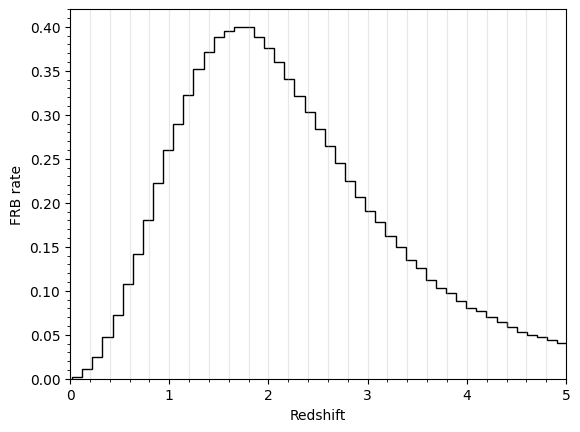

In [101]:
y_hist, bins = np.histogram(frb_dist_z_unlens, bins=100, density=True)
plt.stairs(y_hist, bins, color='k', label='Unlensed')

plt.xlabel('Redshift')
plt.ylabel('FRB rate')

plt.xlim(0, 5)
#plt.yscale('log')

plt.minorticks_on()
plt.tick_params(which='both')
plt.grid(which='both', axis='x', alpha=0.3)

(4.267208911300064e+36, 2.9628843185168956e+42)

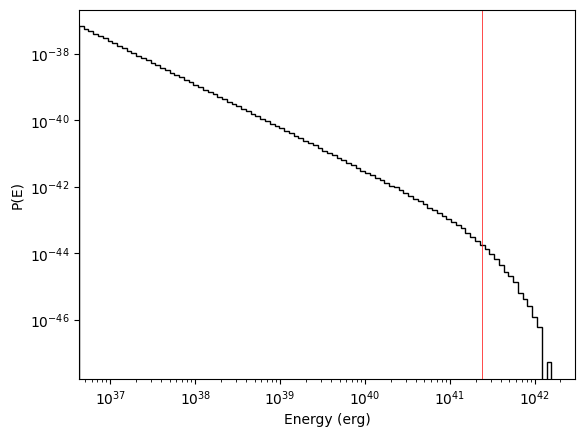

In [102]:
frb_E = np.array(frb_E_dist)

E = np.logspace(np.log10(frb_E.min()),np.log10(frb_E.max()), 100)
y_hist, bins = np.histogram(frb_E, bins=E, density=True)
plt.stairs(y_hist, bins, color='k')

plt.xlabel('Energy (erg)')
plt.ylabel('P(E)')

plt.axvline(frb_properties['Echar'].value, color='r', lw=0.5)

plt.loglog()
plt.xlim(Emin.value, None)

Text(0, 0.5, 'P(S/N)')

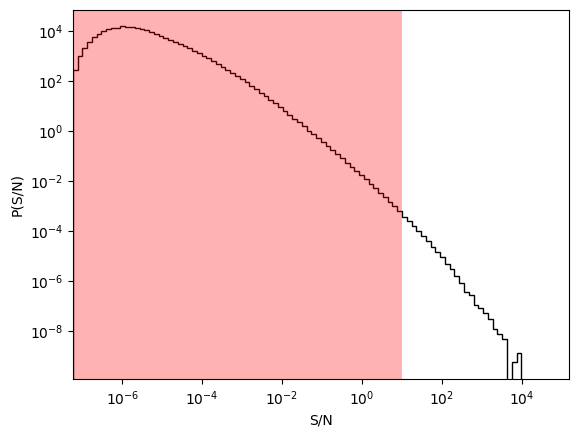

In [110]:
frb_snr = np.array(frb_snr)

snr = np.logspace(np.log10(frb_snr.min()), np.log10(frb_snr.max()), 100)
y_hist, bins = np.histogram(frb_snr, bins=snr, density=True)
plt.stairs(y_hist, bins, color='k')

plt.loglog()
plt.xlim(frb_snr.min(), None)

plt.axvspan(0, 10, color='r', alpha=0.3, lw=0)

plt.xlabel('S/N')
plt.ylabel('P(S/N)')

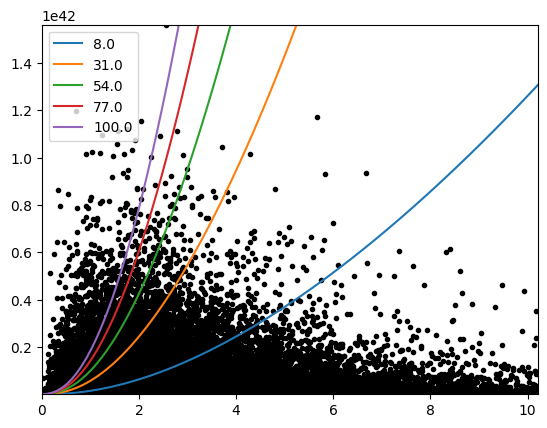

In [104]:
plt.plot(frb_dist_z_unlens, frb_E_dist, 'k.')

z = np.linspace(0, z_max, 100) 
for snr in np.linspace(SNr_min,100,5):
    E = (snr * 4 * np.pi * cosmo.luminosity_distance(z)**2 / (1+z)**(2 + frb_properties['alpha_spect']) / np.sqrt(2 * telescope.bandwidth() / u.ms) * telescope.sefd() * u.GHz).to(u.erg)
    plt.plot(z, E, label=snr)
    
plt.xlim(0,z_max)
plt.ylim(frb_E_dist.min().value, frb_E_dist.max().value)

plt.legend()

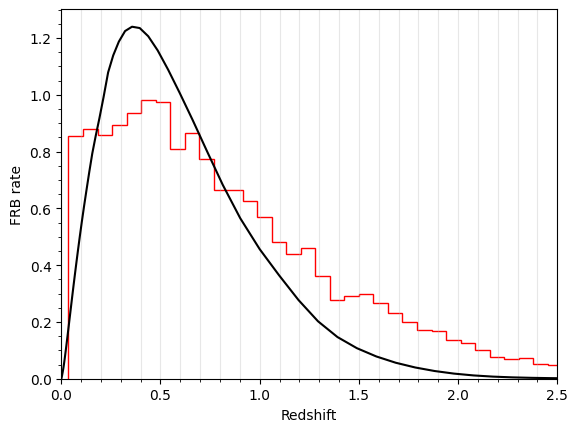

In [111]:
# Distribution of detected FRBs

idx_snr = frb_snr > 10

y_hist, bins = np.histogram(frb_dist_z_unlens[idx_snr], bins=100, density=True)
plt.stairs(y_hist / (bins[1:] + bins[:-1]) * 2, bins, color='r')

plt.xlabel('Redshift')
plt.ylabel('FRB rate')

plt.xlim(0, 2.5)
#plt.yscale('log')

plt.minorticks_on()
plt.tick_params(which='both')
plt.grid(which='both', axis='x', alpha=0.3)

plt.plot(z_K, p_K, 'k-')

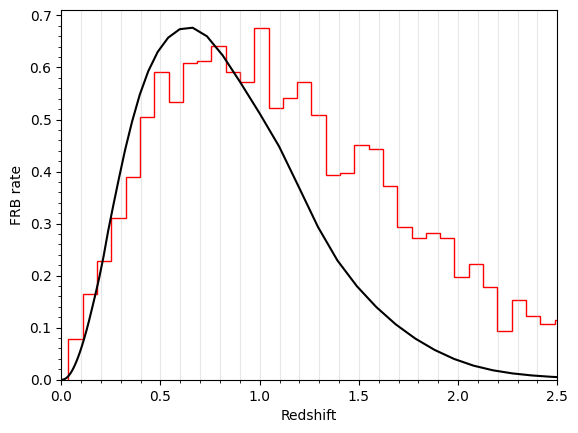

In [112]:
# Distribution of detected FRBs

idx_snr = frb_snr > 20

y_hist, bins = np.histogram(frb_dist_z_unlens[idx_snr], bins=100, density=True)
plt.stairs(y_hist, bins, color='r')

plt.xlabel('Redshift')
plt.ylabel('FRB rate')

plt.xlim(0, 2.5)
#plt.yscale('log')

plt.minorticks_on()
plt.tick_params(which='both')
plt.grid(which='both', axis='x', alpha=0.3)

y_K = p_K * z_K
y_K = y_K / y_K.max() * y_hist.max()
plt.plot(z_K, y_K, 'k-')

In [ ]:
def set_distribution_redshift(
    z_min,
    z_max,
    alpha_rate,
    frb_emission_rate_z0_Epivot,
    n_sfr
):
    """Set the parameters to sample a redshift distribution of a non-evolving population of FRBs.
    """
    # PDF of z distribution
    # Calculate the integrated normalization
    sfr = lambda z: (1 + z)**2.7 / (2.9**5.6 + (1 + z)**5.6)
    z_pdf = lambda z: (
        frb_emission_rate_z0_Epivot * 
        cosmo.differential_comoving_volume(z) * u.sr / 
        (1 + z)**(1-alpha_rate) * (sfr(z) / sfr(0))**n_sfr
    ).to(1 / u.yr).value
    frb_emission_rate = integrate.quad(z_pdf, z_min, z_max)[0]
    # Normalized distribution
    z_pdf_norm = lambda z: z_pdf(z) / frb_emission_rate

In [87]:
frb_emission_rate_z0_Epivot = frb_properties['frb_emission_rate_z0_Epivot']
alpha_rate = frb_properties['alpha_rate']
n_sfr = frb_properties['n_sfr']


# PDF of z distribution
# Calculate the integrated normalization
sfr = lambda z: (1 + z)**2.7 / (2.9**5.6 + (1 + z)**5.6)
sfr = lambda z: 1.0025738 * (1 + z)**2.7 / (1 + ((1 + z) / 2.9)**5.6)
z_pdf = lambda z: (
    frb_emission_rate_z0_Epivot * 
    cosmo.differential_comoving_volume(z) * u.sr / 
    (1 + z) * (sfr(z) / sfr(0))**n_sfr
).to(1 / u.yr).value
frb_emission_rate = integrate.quad(z_pdf, z_min, z_max)[0]
# Normalized distribution
z_pdf_norm = lambda z: z_pdf(z) / frb_emission_rate

In [115]:
z = np.linspace(0, 8, 1000)

In [116]:
frb_emission_rate_z0_Epivot

<Quantity 73000. 1 / (Gpc3 yr)>

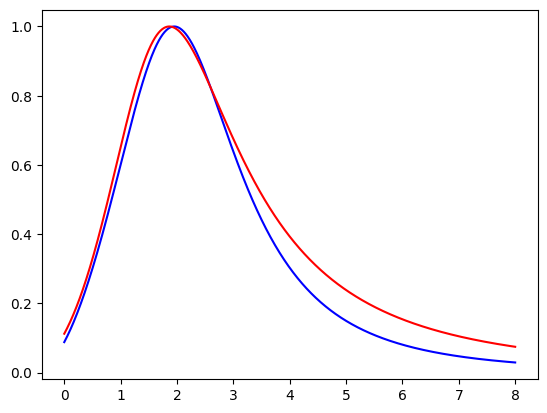

In [126]:

sfr = lambda z: (1 + z)**2.7 / (1 + ((1 + z) / 2.9)**5.6)

z_pdf = lambda z: (
    cosmo.differential_comoving_volume(z) * u.sr / u.yr / u.Gpc**3 / 
    (1 + z) * (sfr(z) / sfr(0))
).to(1 / u.yr).value

z_pdf = lambda z: (
    1 / u.yr / 
    (1 + z) * (sfr(z-0.4) / sfr(0))
).to(1 / u.yr).value

sfr_pdf = lambda z: sfr(z) / sfr(0)

plt.plot(z, z_pdf(z) / z_pdf(z).max(), 'b-')
plt.plot(z, sfr_pdf(z) / sfr_pdf(z).max(), 'r-')

(0.01, 1.1)

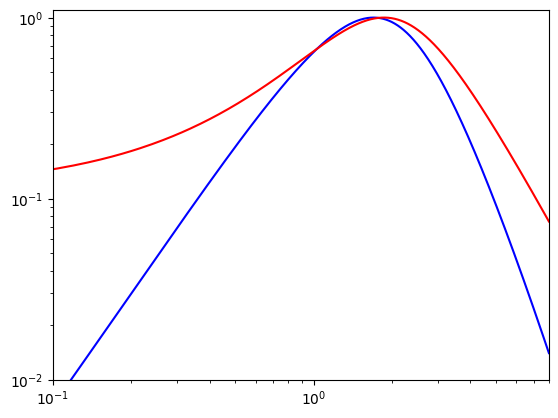

In [119]:
plt.plot(z, z_pdf(z) / z_pdf(z).max(), 'b-')
plt.plot(z, sfr_pdf(z) / sfr_pdf(z).max(), 'r-')

plt.loglog()
plt.xlim(0.1,8)
plt.ylim(1e-2, 1.1)

In [120]:
sfr_pdf(0)

1.0

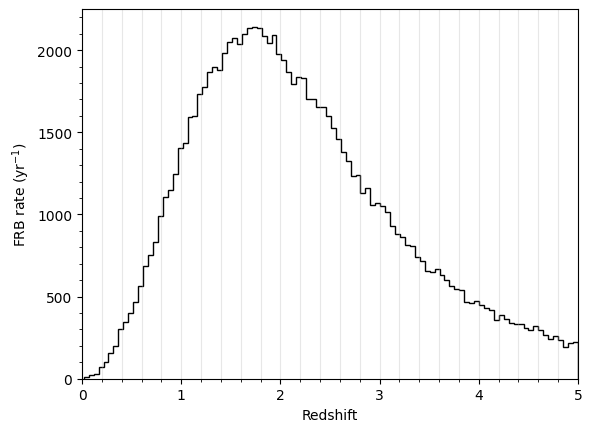

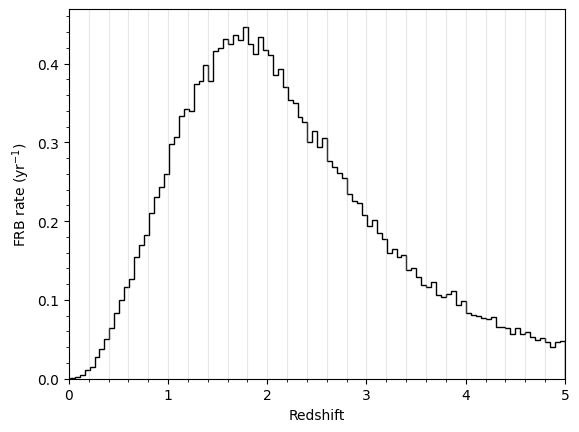

In [130]:
y_hist, bins = np.histogram(frb_dist_z_unlens, bins=100, density=True)
plt.stairs(y_hist, bins, color='k', label='Unlensed')


plt.xlabel('Redshift')
plt.ylabel('FRB rate (yr$^{-1}$)')

plt.xlim(0, 5)
#plt.yscale('log')

plt.minorticks_on()
plt.tick_params(which='both')
plt.grid(which='both', axis='x', alpha=0.3)

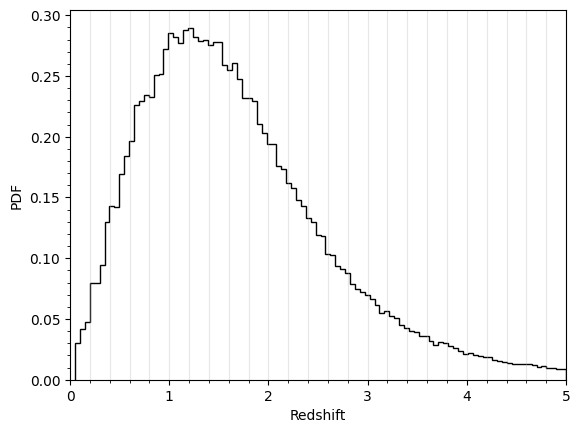

In [ ]:
plt.stairs(y_hist / bins[1:], bins, color='k', label='Unlensed')

plt.xlabel('Redshift')
plt.ylabel('PDF')

plt.xlim(0, 5)
#plt.yscale('log')

plt.minorticks_on()
plt.tick_params(which='both')
plt.grid(which='both', axis='x', alpha=0.3)

In [ ]:
# Energy distribution



In [61]:
# Discovery rates of sl-FRBs
number_of_simulated_frbs = set_simulation_size('test')
number_of_simulated_frbs

10000

In [62]:
# argos + GBT
print('argos + GBT')
telescope_name = 'argos'
telescope_followup = 'gbt'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()

# argos + DSA-2000
print('argos + DSA-2000')
telescope_name = 'argos'
telescope_followup = 'dsa2000'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()


# argos + argos
print('argos + argos')
telescope_name = 'argos'
telescope_followup = 'argos'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()

argos + GBT
0.0860 # 0.0054 / 0.2985
0.0860 - 0.0806 + 0.2124
0.0552

argos + DSA-2000
0.1114 # 0.0089 / 0.5375
0.1114 - 0.1026 + 0.4261
0.0806

argos + argos
0.1087 # 0.0079 / 0.1930
0.1087 - 0.1008 + 0.0843
0.0504



In [63]:
frbs_narrowband = False

# argos + GBT
print('argos + GBT')
telescope_name = 'argos'
telescope_followup = 'gbt'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()

# argos + DSA-2000
print('argos + DSA-2000')
telescope_name = 'argos'
telescope_followup = 'dsa2000'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()


# argos + argos
print('argos + argos')
telescope_name = 'argos'
telescope_followup = 'argos'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()

argos + GBT
0.0544 # 0.0040 / 0.2945
0.0544 - 0.0504 + 0.2401
0.0381

argos + DSA-2000
0.0608 # 0.0030 / 0.2395
0.0608 - 0.0579 + 0.1787
0.0301

argos + argos
0.0634 # 0.0090 / 0.1877
0.0634 - 0.0544 + 0.1243
0.0307



In [440]:
# sl-FRBs detection rates

In [4]:
# CHORD + GBT
print('CHORD + GBT')
telescope_name = 'chord'
telescope_followup = 'gbt'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()


# CHORD + DSA-2000
print('CHORD + DSA-2000')
telescope_name = 'chord'
telescope_followup = 'dsa2000'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()


# DSA-2000 + GBT
print('DSA-2000 + GBT')
telescope_name = 'dsa2000'
telescope_followup = 'gbt'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()


# DSA-2000 + DSA-2000
print('DSA-2000 + DSA-2000')
telescope_name = 'dsa2000'
telescope_followup = 'dsa2000'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()

CHORD + GBT
0.2206 # 0.0683 / 1.4436
0.2206 - 0.1523 + 1.2229
0.1921

CHORD + DSA-2000
0.2508 # 0.0938 / 1.3732
0.2508 - 0.1570 + 1.1224
0.3178

DSA-2000 + GBT
0.3537 # 0.1565 / 2.2291
0.3537 - 0.1972 + 1.8754
0.5239

DSA-2000 + DSA-2000
0.4748 # 0.2028 / 3.4431
0.4748 - 0.2720 + 2.9682
0.6989



In [64]:
frbs_narrowband = False

# CHORD + GBT
print('CHORD + GBT')
telescope_name = 'chord'
telescope_followup = 'gbt'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()


# CHORD + DSA-2000
print('CHORD + DSA-2000')
telescope_name = 'chord'
telescope_followup = 'dsa2000'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()


# DSA-2000 + GBT
print('DSA-2000 + GBT')
telescope_name = 'dsa2000'
telescope_followup = 'gbt'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()


# DSA-2000 + DSA-2000
print('DSA-2000 + DSA-2000')
telescope_name = 'dsa2000'
telescope_followup = 'dsa2000'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()

CHORD + GBT
0.2099 # 0.0659 / 1.5579
0.2099 - 0.1440 + 1.3480
0.2643

CHORD + DSA-2000
0.2448 # 0.0838 / 1.2230
0.2448 - 0.1610 + 0.9782
0.4236

DSA-2000 + GBT
0.3445 # 0.1139 / 1.5699
0.3445 - 0.2306 + 1.2255
0.4705

DSA-2000 + DSA-2000
0.4581 # 0.1617 / 1.9173
0.4581 - 0.2964 + 1.4593
0.4837



In [8]:
# Total number of FRBs
print(0.2206 / 3 * 2 + 0.2508 / 3+ 0.3537 / 3 * 2 + 0.4748 / 3 )
print(0.0683 / 3 * 2 + 0.0938 / 3+ 0.1565 / 3 * 2 + 0.2028 / 3 )
print(1.4436 / 3 * 2 + 1.3732 / 3+ 2.2291 / 3 * 2 + 3.4431 / 3 )

0.6247333333333334
0.24873333333333336
4.0539000000000005


In [ ]:
0.2508 / 3 + 0.2206 / 3 * 2 + 0.4748 / 3 + 0.3537 / 3 * 2

In [5]:
# CHORD + GBT
print('CHORD + GBT')
telescope_name = 'chord'
telescope_followup = 'gbt'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()


# CHORD + DSA-2000
print('CHORD + DSA-2000')
telescope_name = 'chord'
telescope_followup = 'dsa2000'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()


# CHORD + CHORD
print('CHORD + CHORD')
telescope_name = 'chord'
telescope_followup = 'chord'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)
print(f'{frb_detection_rate.value:.4f} # {frb_detection_rate_low.value:.4f} / {frb_detection_rate_high.value:.4f}')
print(f'{frb_detection_rate.value:.4f} - {(frb_detection_rate - frb_detection_rate_low).value:.4f} + {(frb_detection_rate_high - frb_detection_rate).value:.4f}')
print(f'{uncert_med.value:.4f}')
print()

CHORD + GBT
0.2206 # 0.0683 / 1.4436
0.2206 - 0.1523 + 1.2229
0.1921

CHORD + DSA-2000
0.2508 # 0.0938 / 1.3732
0.2508 - 0.1570 + 1.1224
0.3178

CHORD + CHORD
0.2171 # 0.0756 / 2.0280
0.2171 - 0.1415 + 1.8110
0.3317



In [ ]:
# CHORD + GBT
print('CHORD + GBT')
telescope_name = 'chord'
telescope_followup = 'gbt'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)

print(f'{frb_detection_rate.value:.2f} # {frb_detection_rate_low.value:.2f} / {frb_detection_rate_high.value:.2f}')
print(f'{frb_detection_rate.value:.2f} - {(frb_detection_rate - frb_detection_rate_low).value:.2f} + {(frb_detection_rate_high - frb_detection_rate).value:.2f}')
print(f'{uncert_med.value:.2f}')
print()

# CHORD + DSA-2000
telescope_name = 'chord'
telescope_followup = 'dsa2000'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)

print(f'{frb_detection_rate.value:.2f} # {frb_detection_rate_low.value:.2f} / {frb_detection_rate_high.value:.2f}')
print(f'{frb_detection_rate.value:.2f} - {(frb_detection_rate - frb_detection_rate_low).value:.2f} + {(frb_detection_rate_high - frb_detection_rate).value:.2f}')
print(uncert_med)

# DSA-2000 + GBT
telescope_name = 'dsa2000'
telescope_followup = 'gbt'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)

print(f'{frb_detection_rate.value:.2f} # {frb_detection_rate_low.value:.2f} / {frb_detection_rate_high.value:.2f}')
print(f'{frb_detection_rate.value:.2f} - {(frb_detection_rate - frb_detection_rate_low).value:.2f} + {(frb_detection_rate_high - frb_detection_rate).value:.2f}')
print(uncert_med)

# DSA-2000 + DSA-2000
telescope_name = 'dsa2000'
telescope_followup = 'dsa2000'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    number_of_simulated_frbs,
    telescope_name = telescope_name,
    simulate_lensed_frbs = True,
)

print(f'{frb_detection_rate.value:.2f} # {frb_detection_rate_low.value:.2f} / {frb_detection_rate_high.value:.2f}')
print(f'{frb_detection_rate.value:.2f} - {(frb_detection_rate - frb_detection_rate_low).value:.2f} + {(frb_detection_rate_high - frb_detection_rate).value:.2f}')
print(uncert_med)

In [54]:
# Redshift distribution of detected FRBs

# CHIME
chime_z_dist = run_simulation(
    int(1e6),
    telescope_name = 'chime',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

# ASKAP
askap_z_dist = run_simulation(
    int(1e7),
    telescope_name = 'askap',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

# CHORD
chord_z_dist = run_simulation(
    int(1e5),
    telescope_name = 'chord',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

# DSA-2000
dsa_z_dist = run_simulation(
    int(1e5),
    telescope_name = 'dsa2000',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

(0.0, 5.0)

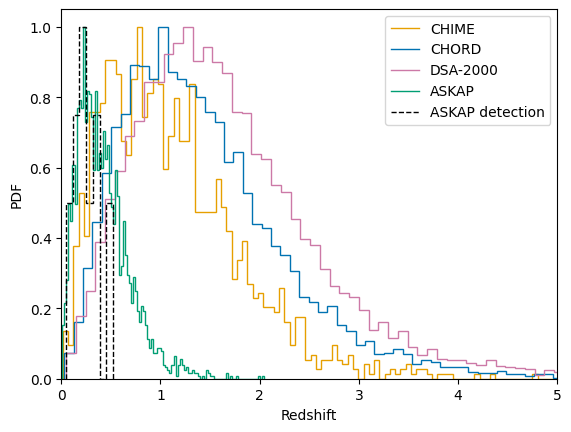

In [87]:
# Color-blind friendly, from https://www.nature.com/articles/nmeth.1618
color = (np.array([
    (  0,   0,   0),
    (230, 159,   0),
    ( 86, 180, 233),
    (  0, 158, 115),
    (240, 228,  66),
    (  0, 114, 178),
    (213,  94,   0),
    (204, 121, 167),
]) / 255).tolist()

y_hist, bins = np.histogram(chime_z_dist, bins=100, density=True)
plt.stairs(y_hist/y_hist.max(), bins, color=color[1], label='CHIME')

y_hist, bins = np.histogram(chord_z_dist, bins=100, density=True)
plt.stairs(y_hist/y_hist.max(), bins, color=color[5], label='CHORD')

y_hist, bins = np.histogram(dsa_z_dist, bins=100, density=True)
plt.stairs(y_hist/y_hist.max(), bins, color=color[7], label='DSA-2000')

y_hist, bins = np.histogram(askap_z_dist, bins=100, density=True)
plt.stairs(y_hist/y_hist.max(), bins, color=color[3], label='ASKAP')

ASKAP_FRBs = [0.23, 0.161, 0.36879, 0.12927, 0.2797, 0.3214, 0.4755, 0.291, 0.1178, 0.378, 0.522, 0.209, 0.243, 0.2145, 0.0469, 0.0715]
# from https://ui.adsabs.harvard.edu/abs/2022MNRAS.516.4862J/abstract
y_hist, bins = np.histogram(ASKAP_FRBs, bins=7, density=True)
plt.stairs(y_hist/y_hist.max(), bins, color='k', label='ASKAP detection') #, ls='--'

plt.xlabel('Redshift')
plt.ylabel('PDF')
plt.legend()

plt.xlim(0, 5)

In [ ]:
rng = default_rng(seed)  # Random generator; seed fixed for reproducibility
observing_time_fraction = 1  # Fraction of observing time
number_of_simulated_frbs = int(1e6)
SNr_min = 12

t = 'chime'
telescope = t.lower()
# Shin model
value = run_simulation(
        number_of_simulated_frbs,
        telescope_name = telescope,
        simulate_lensed_frbs = False,
        model = 'shin',
        uncertain = False,
        verbose = False,
    ).to(1/u.yr).value
uncert = np.array([
    run_simulation(
        number_of_simulated_frbs // 100,
        telescope_name = telescope,
        simulate_lensed_frbs = False,
        model = 'shin',
        uncertain = True,
        verbose = False
    ).to(1/u.yr).value for n in range(100)
])
uncert_down = np.percentile(uncert[uncert>0], 16)
uncert_up = np.percentile(uncert[uncert>0], 84)
med = np.median(uncert[uncert>0])

In [ ]:
value, uncert_down, uncert_up, med

In [3]:
# Redshift distribution

In [4]:
frb_properties = FRB_Population(name='shin').get_parameters()

(
    frb_dist_fact,
    z_min,
    z_max,
    frb_emission_rate,
    hosts,
    frb_dist_z_lens
) = get_distribution_dist(
    int(1e5),
    frb_properties['alpha_spect'],
    frb_properties['alpha_rate'],
    frb_properties['frb_emission_rate_z0_Epivot'],
    frb_properties['n_sfr'],
    simulate_lensed_frbs = True,
    frbs_evolve_with_luminosity = True,
)

(
    frb_dist_fact,
    z_min,
    z_max,
    frb_emission_rate,
    hosts,
    frb_dist_z_unlens
) = get_distribution_dist(
    int(1e5),
    frb_properties['alpha_spect'],
    frb_properties['alpha_rate'],
    frb_properties['frb_emission_rate_z0_Epivot'],
    frb_properties['n_sfr'],
    simulate_lensed_frbs = False,
    frbs_evolve_with_luminosity = True,
    z_min = z_min,
    z_max = z_max
)

In [ ]:
lensed_fraction = gf(lensed_fraction, 6)

(0.0, 4.353177842565598)

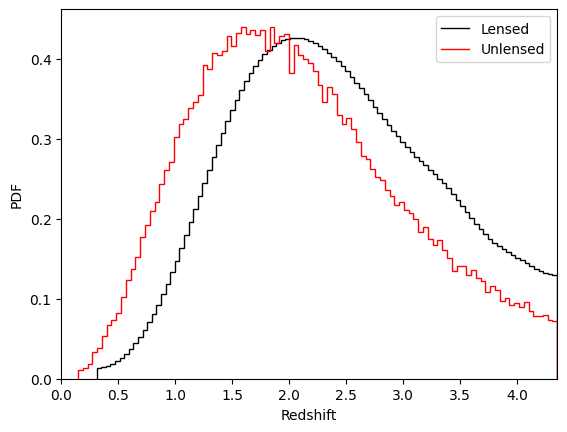

In [12]:
y_hist, bins = np.histogram(frb_dist_z_lens, bins=100, density=True)
plt.stairs(gf(y_hist, 6), bins, color='k', label='Lensed')

y_hist, bins = np.histogram(frb_dist_z_unlens, bins=100, density=True)
plt.stairs(y_hist, bins, color='r', label='Unlensed')

plt.xlabel('Redshift')
plt.ylabel('PDF')
plt.legend()

plt.xlim(0, z_max)

In [25]:
# Get processing time
# simulate_lensed_frbs = True

from time import time

telescope_followup = 'dsa2000'
times = []
n_frbs = [100, 1000, 10_000, 100_000]
for n in n_frbs:
    t0 = time()
    _ = run_simulation(
        n,
        telescope_name='dsa2000',
        simulate_lensed_frbs = True,
        model = 'shin',
        uncertain = False,
        frbs_evolve_with_luminosity = True,
        verbose = False
    )
    times.append(time() - t0)
    
plt.plot(times, n_frbs, 'ko')
plt.plot([times[0], times[-1]], [n_frbs[0], n_frbs[-1]], 'r-')

#1e6 FRBs
print((times[-1] - times[-2]) / (n_frbs[-1] - n_frbs[-2]) * 1e6)

1.01 s ± 229 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [123]:
# Plot of measured vs simulated rate for different telescopes

# Measured detection rates
telescope_rates = {}

#CHIME (https://arxiv.org/pdf/2106.04352.pdf)
n_frbs = 536
obs_time = 214.8 * 24 * u.hour
rate = (n_frbs / obs_time).to(1/u.yr)
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr)
telescope_rates['CHIME'] = [rate, err]

#FAST (https://ui.adsabs.harvard.edu/abs/2021ApJ...909L...8N/abstract)
n_frbs = 4
obs_time = (1667 + 9) * u.hour
rate = (n_frbs / obs_time).to(1/u.yr) / 9  # 9 to correct for multi-beam receiver
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr) / 9
telescope_rates['FAST'] = [rate, err]

# ASKAP (https://ui.adsabs.harvard.edu/abs/2018Natur.562..386S/abstract)
n_frbs = 20
obs_time = 32_840 * u.hour
rate = (n_frbs / obs_time).to(1/u.yr)
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr)
telescope_rates['ASKAP'] = [rate, err]

# Aperitif (https://ui.adsabs.harvard.edu/abs/2023A%26A...672A.117V/abstract)
n_frbs = 5
obs_time = 800 * u.hour
rate = (n_frbs / obs_time).to(1/u.yr) / 40  # 40 to correct for compound beams
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr) / 40
telescope_rates['Aperitif'] = [rate, err]

# UTMOST (https://ui.adsabs.harvard.edu/abs/2019MNRAS.488.2989F/abstract)
n_frbs = 6
obs_time = (344 * u.day).to(u.hour)
rate = (n_frbs / obs_time).to(1/u.yr)
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr)
telescope_rates['UTMOST'] = [rate, err]

# Parkes (https://ui.adsabs.harvard.edu/abs/2016MNRAS.460L..30C/abstract)
n_frbs = 9
obs_time = (33_500 * 270 * u.s).to(u.hour)
rate = (n_frbs / obs_time).to(1/u.yr) / 13  # 13 to correct for multi-beam receiver
err = (np.sqrt(n_frbs) / obs_time).to(1/u.yr) / 13
telescope_rates['Parkes'] = [rate, err]

# CHORD (https://ui.adsabs.harvard.edu/abs/2019clrp.2020...28V/abstract)
telescope_rates['CHORD'] = [25.5 * 365 / u.yr, 7 * 365 / u.yr]

# DSA2000 (https://ui.adsabs.harvard.edu/abs/2019BAAS...51g.255H/abstract)
telescope_rates['DSA2000'] = [1e4 / u.yr, 5e3 / u.yr]

telescope_list = sorted(telescope_rates.keys(), key=lambda v: v.upper())

In [161]:
rng = default_rng(seed)  # Random generator; seed fixed for reproducibility
number_of_simulated_frbs = number_of_simulated_frbs  # Elements in the simulation
observing_time_fraction = 1  # Fraction of observing time

shin_values = []
shin_uncert_up = []
shin_uncert_down = []
med = []
for t in telescope_list:
    print(t)
    telescope = t.lower()
    # Shin model
    value = run_simulation(
            number_of_simulated_frbs,
            telescope_name = telescope,
            simulate_lensed_frbs = False,
            model = 'shin',
            uncertain = False,
            verbose = False,
        ).to(1/u.yr).value
    uncert = np.array([
        run_simulation(
            number_of_simulated_frbs // 100,
            telescope_name = telescope,
            simulate_lensed_frbs = False,
            model = 'shin',
            uncertain = True,
            verbose = False
        ).to(1/u.yr).value for n in range(100)
    ])
    shin_values.append(value)
    shin_uncert_down.append(np.percentile(uncert[uncert>0], 16))
    shin_uncert_up.append(np.percentile(uncert[uncert>0], 84))
    med.append(np.median(uncert[uncert>0]))
    
shin_values = np.array(shin_values) / u.yr
shin_uncert_down = np.array(shin_uncert_down) / u.yr
shin_uncert_up = np.array(shin_uncert_up) / u.yr

Aperitif
ASKAP
CHIME
CHORD
DSA2000
FAST
Parkes
UTMOST


Text(0, 0.5, 'Rate (1/yr)')

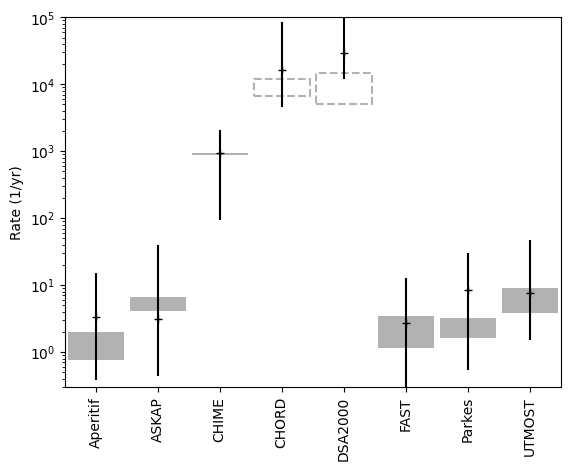

In [171]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots()

x = np.arange(len(telescope_list))
ax.errorbar(
    x,
    shin_values,
    yerr=(shin_values-shin_uncert_down, shin_uncert_up-shin_values),
    fmt='k+',
    label='Shin+ 2023',
    zorder=5
)
#ax.errorbar(x, shin_values_r, yerr=shin_uncert_r, fmt='r+', label='(rate interpretation)', zorder=5)
#ax.errorbar(x+0.1, james_values, yerr=james_uncert, fmt='g+', label='James+ 2023', zorder=5)

#ax.plot(x-0.1, shin_values, 'k+', label='Shin+ 2023', zorder=5)
#ax.plot(x, shin_values_r, 'r+', label='(rate interpretation)', zorder=5)
#ax.plot(x+0.1, james_values, 'g+', label='James+ 2023', zorder=5)
#ax.plot(x, med, 'r+', zorder=6)


for telescope, xi in zip(telescope_list, x):
    rate = telescope_rates[telescope]
    if telescope.lower() in ['chord', 'dsa2000']:
        rect = Rectangle(
            (xi - 0.45, (rate[0] - rate[1]).to(1/u.yr).value),
            0.9,
            rate[1].to(1/u.yr).value * 2,
            alpha=0.3,
            color='k',
            fc='none',
            hatch = hatch,
            ls = '--',
            lw = 1.5
        )
    else:
        rect = Rectangle(
            (xi - 0.45, (rate[0] - rate[1]).to(1/u.yr).value),
            0.9,
            rate[1].to(1/u.yr).value * 2,
            alpha=0.3,
            color='k',
            ec='none',
            hatch = hatch
        )
    ax.add_patch(rect)

#ax.legend()
ax.set_yscale('log')
ax.set_xlim(x.min()-0.5, x.max()+0.5)
ax.set_ylim(0.3, 100_000)
ax.set_xticks(x)
ax.set_xticklabels(telescope_list, rotation='vertical')
ax.set_ylabel("Rate (1/yr)")

In [62]:
# Fraction of sky observed by CHORD at maximum elevation

In [53]:
a=EarthLocation.of_site('DRAO')

In [59]:
dec = a.lat + 30 * u.deg

In [60]:
360 / (np.sqrt(130/np.pi)*2 / np.cos(np.deg2rad(dec)))

<Quantity 5.18519854>

In [61]:
360 / (np.sqrt(5/np.pi)*2 / np.cos(np.deg2rad(dec)))

<Quantity 26.43942853>

In [63]:
30000 / 10.6

2830.1886792452833

In [37]:
# Follow-up
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time

In [4]:
source_low_dec = SkyCoord(ra=0*u.deg, dec=-10*u.deg)
source_mid_dec = SkyCoord(ra=0*u.deg, dec=45*u.deg)
source_high_dec = SkyCoord(ra=0*u.deg, dec=89*u.deg)

In [5]:
gbt = EarthLocation.of_site('GBT')
gmrt = EarthLocation.of_site('GMRT')
eff = EarthLocation.of_site('Effelsberg')

90.0% of time the source can be observed


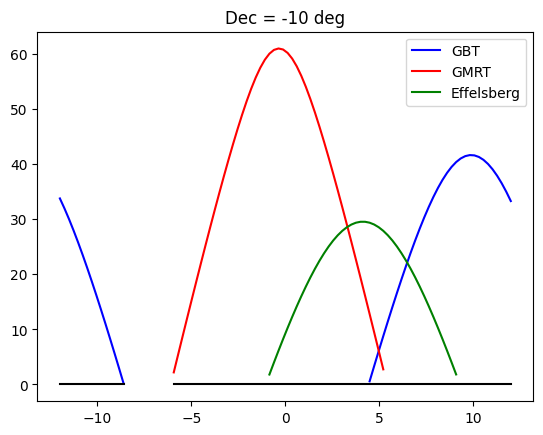

In [26]:
# Low dec
ha = np.linspace(-12, 12, 100)
t = ha*u.hour + Time('2012-7-13 00:00:00')
y_t = np.zeros_like(ha) + np.nan

# GBT
alt_gbt = source_low_dec.transform_to(AltAz(obstime=t, location=gbt)).alt
idx = alt_gbt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gbt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'b-', label='GBT')
y_t[idx] = 0

# GMRT
alt_gmrt = source_low_dec.transform_to(AltAz(obstime=t, location=gmrt)).alt
idx = alt_gmrt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gmrt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'r-', label='GMRT')
y_t[idx] = 0

# Effelsberg
alt_eff = source_low_dec.transform_to(AltAz(obstime=t, location=eff)).alt
idx = alt_eff > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_eff.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'g-', label='Effelsberg')
y_t[idx] = 0

plt.plot(ha, y_t, "k-")
plt.legend()
plt.title('Dec = -10 deg')

print(f'{y_t[~np.isnan(y_t)].size / y_t.size * 100:.1f}% of time the source can be observed')

100.0% of time the source can be observed


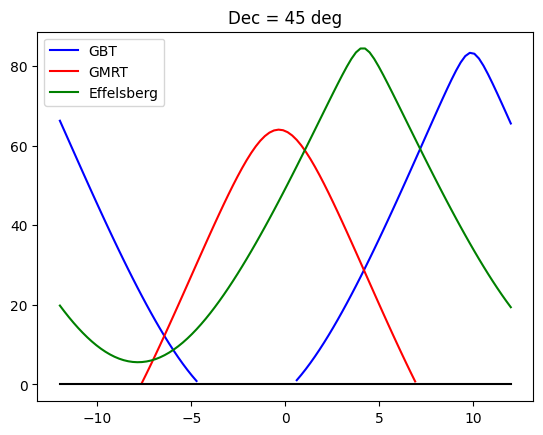

In [27]:
# Mid dec
ha = np.linspace(-12, 12, 100)
t = ha*u.hour + Time('2012-7-13 00:00:00')
y_t = np.zeros_like(ha) + np.nan

# GBT
alt_gbt = source_mid_dec.transform_to(AltAz(obstime=t, location=gbt)).alt
idx = alt_gbt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gbt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'b-', label='GBT')
y_t[idx] = 0

# GMRT
alt_gmrt = source_mid_dec.transform_to(AltAz(obstime=t, location=gmrt)).alt
idx = alt_gmrt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gmrt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'r-', label='GMRT')
y_t[idx] = 0

# Effelsberg
alt_eff = source_mid_dec.transform_to(AltAz(obstime=t, location=eff)).alt
idx = alt_eff > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_eff.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'g-', label='Effelsberg')
y_t[idx] = 0

plt.plot(ha, y_t, "k-")
plt.legend()
plt.title('Dec = 45 deg')

print(f'{y_t[~np.isnan(y_t)].size / y_t.size * 100:.1f}% of time the source can be observed')

100.0% of time the source can be observed


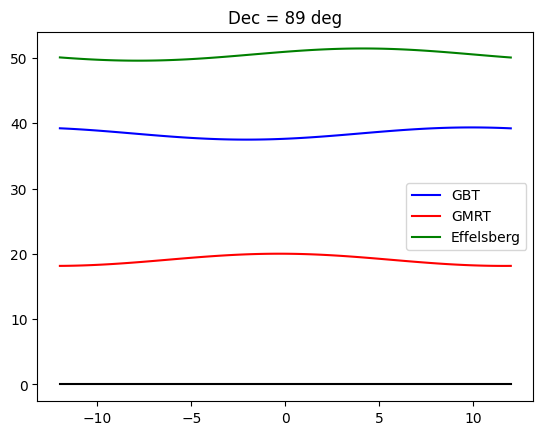

In [28]:
# High dec
ha = np.linspace(-12, 12, 100)
t = ha*u.hour + Time('2012-7-13 00:00:00')
y_t = np.zeros_like(ha) + np.nan

# GBT
alt_gbt = source_high_dec.transform_to(AltAz(obstime=t, location=gbt)).alt
idx = alt_gbt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gbt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'b-', label='GBT')
y_t[idx] = 0

# GMRT
alt_gmrt = source_high_dec.transform_to(AltAz(obstime=t, location=gmrt)).alt
idx = alt_gmrt > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_gmrt.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'r-', label='GMRT')
y_t[idx] = 0

# Effelsberg
alt_eff = source_high_dec.transform_to(AltAz(obstime=t, location=eff)).alt
idx = alt_eff > 0
x = ha.copy()
x[~idx] = np.nan
y = alt_eff.value.copy()
y[~idx] = np.nan
plt.plot(x, y, 'g-', label='Effelsberg')
y_t[idx] = 0

plt.plot(ha, y_t, "k-")
plt.legend()
plt.title('Dec = 89 deg')

print(f'{y_t[~np.isnan(y_t)].size / y_t.size * 100:.1f}% of time the source can be observed')

Text(0, 0.5, 'FRBs')

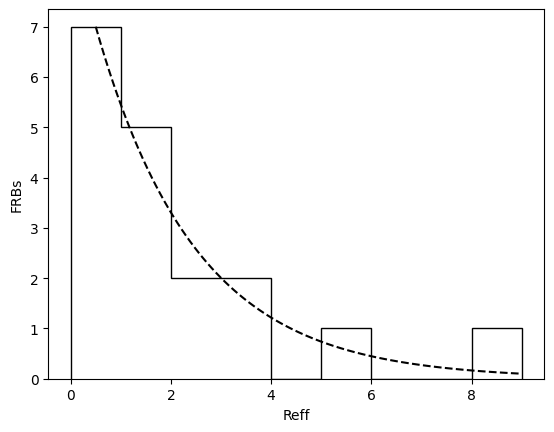

In [431]:
# FRB radial distribution within host galaxies

#https://arxiv.org/pdf/2009.10747.pdf
#https://arxiv.org/pdf/2302.14782.pdf
#https://arxiv.org/pdf/2108.01282.pdf
#https://arxiv.org/pdf/2301.01000.pdf

# i-band and r-band
offset = np.array([0.6, 5.5, 3.4, 1.2, 2.0, 27, 6.6, 11, 3.2, 1.9, 11, 3.0, 9.87, 3.80, 10.8, 5.7, 5.9, 2.3])
reff = np.array([0.7, 3.6, 2.7, 7.2, 4.4, 3.3, 2.8, 2.1, 2.9, 3.9, 5.5, 1.6, 2.67, 6.64, 5.80, 1.78, 7.58, 2.7])

r = np.sort(offset / reff)
F = np.arange(r.size)/r.size

from scipy import stats
y_hist, bins = np.histogram(r, bins=np.arange(10), density=False)
plt.stairs(y_hist, bins, color='k')

x = np.linspace(0, x_hist.max(), 100)
y = np.exp(-x/2)
plt.plot(x+0.5, y*y_hist.max(), 'k--', label='exp(dR)')
plt.xlabel('Reff')
plt.ylabel('FRBs')

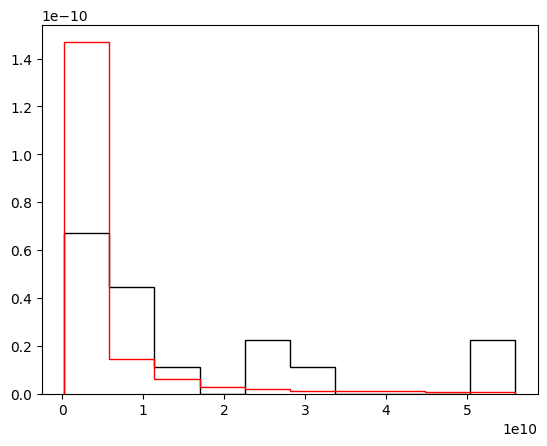

In [167]:
# Host luminosity distribution
mag = np.array([-16.20, -19.46, -20.81, -20.40, -19.85, -22.06, -21.22, -19.01, -19.92, -22.13, -18.05, -18.80, -21.38, -20.18, -18.26, -21.49]) * u.M_bol
y_hist, bins = np.histogram(mag.to(u.L_sun).value, bins=10, density=True)
plt.stairs(y_hist, bins, color='k')

M_org = np.loadtxt('lsst_source_catalog.txt', usecols=7, delimiter=',') * u.M_bol
z_org = np.loadtxt('lsst_source_catalog.txt', usecols=2, delimiter=',')
M_org = M_org[z_org<1]
y_hist_org, bins = np.histogram(M_org.to(u.L_sun).value, bins=bins, density=True)
plt.stairs(y_hist_org, bins, color='r')

([], [])

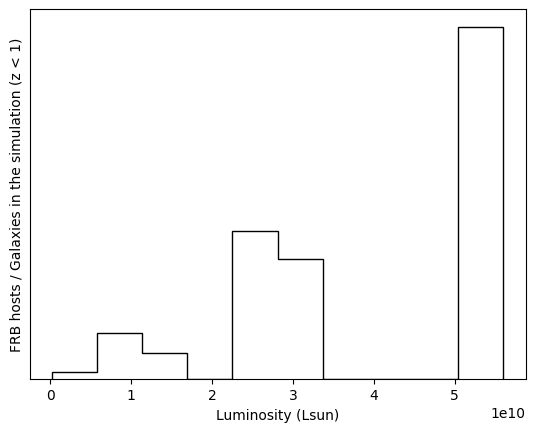

In [169]:
plt.stairs(y_hist / y_hist_org, bins, color='k')
plt.xlabel('Luminosity (Lsun)')
plt.ylabel('FRB hosts / Galaxies in the simulation (z < 1)')
plt.yticks([])

([], [])

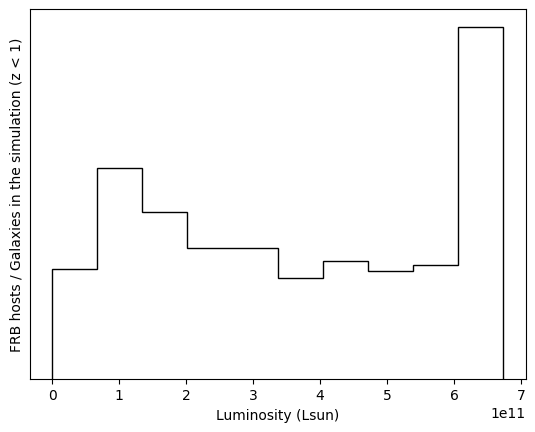

In [171]:
M_sim = np.loadtxt('lenses_Euclid.txt', usecols=15, skiprows=1) * u.M_bol # Magnitude distribution
z_sim = np.loadtxt('lenses_Euclid.txt', usecols=1, skiprows=1)  # Redshift distribution
y_hist_sim, bins = np.histogram(M_sim.to(u.L_sun).value, density=True)

M_org = np.loadtxt('lsst_source_catalog.txt', usecols=7, delimiter=',') * u.M_bol
z_org = np.loadtxt('lsst_source_catalog.txt', usecols=2, delimiter=',')
y_hist_org, bins = np.histogram(M_org.to(u.L_sun).value, bins=bins, density=True)

plt.stairs(y_hist_sim / y_hist_org, bins, color='k')
plt.xlabel('Luminosity (Lsun)')
plt.ylabel('FRB hosts / Galaxies in the simulation (z < 1)')
plt.yticks([])

In [17]:
sie = pd.read_csv(data_sie_catalog, index_col=['q', 0])

In [25]:
sie['mu_3'].min()

0.0

In [19]:
sie.loc[:,["mu_1", "mu_2", "mu_3", "mu_4"]]

mu_1    mu_2    mu_3    mu_4
q                                          
0.01 0       1.1197  0.4740  0.0000  0.0000
     1       1.1244  0.1137  0.0000  0.0000
     2       1.2738  1.2018  0.0233  0.0156
     3       1.2620  1.2105  0.0264  0.0094
     4       1.2443  1.2237  0.0163  0.0161
...             ...     ...     ...     ...
0.99 443228  5.7176  3.4901  0.0000  0.0000
     443229  5.2826  3.2180  0.0000  0.0000
     443230  5.8767  4.2164  0.0000  0.0000
     443231  3.5615  1.4803  0.0000  0.0000
     443232  2.0344  0.0446  0.0000  0.0000

[443233 rows x 4 columns]

In [5]:
import numpy as np
from numpy.random import default_rng
from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from scipy.interpolate import CubicSpline as spline
from scipy import integrate
from mpmath import gammainc


def sample_distribution_redshift(
    number_of_simulated_frbs,
    z_min,
    z_max,
    alpha_rate,
    frb_emission_rate_z0_Epivot,
    n_sfr
):
    """Sample a redshift distribution of FRBs.
    """
    # PDF of z distribution
    # Calculate the integrated normalization
    sfr = lambda z: (1 + z)**2.7 / (2.9**5.6 + (1 + z)**5.6)
    z_pdf = lambda z: (
        frb_emission_rate_z0_Epivot * 
        cosmo.differential_comoving_volume(z) * u.sr / 
        (1 + z)**(1-alpha_rate) * (sfr(z) / sfr(0))**n_sfr
    ).to(1 / u.yr).value
    frb_emission_rate = integrate.quad(z_pdf, z_min, z_max)[0]
    # Normalized distribution
    z_pdf_norm = lambda z: z_pdf(z) / frb_emission_rate

    # Find maximum of distribution with a spline and its derivative
    # Mock data
    z = np.linspace(z_min, z_max, 1000)
    P_z = z_pdf_norm(z)
    # Spline interpolation
    cs = spline(z, P_z)
    # Redshift of null derivatives
    roots = cs.derivative().roots()
    # Location of the maximum of the curve
    curve_max = z[P_z.argmax()]
    # Redshift of the null derivative closest to the location of the maximum
    x_max = roots[np.argmin(np.abs(roots - curve_max))]
    # Maximum of the distribution plus 1% to account for granularity
    y_max = z_pdf_norm(x_max)
    y_max = y_max + 0.01 * y_max
    
    # Rejection sampling the distribution
    z_dist = np.zeros(number_of_simulated_frbs) + np.nan
    # Loop until no nan are present
    while np.isnan(z_dist).any():
        # Random values in a box around the function
        x = rng.uniform(low=z_min, high=z_max, size=number_of_simulated_frbs)
        y = rng.uniform(low=0, high=y_max, size=number_of_simulated_frbs)
        # Resize the arrays to get the right number of bins
        nan_size = z_dist[np.isnan(z_dist)].size
        x = x[y < z_pdf_norm(x)][:nan_size]
        first_nan = np.argmax(z_dist)
        z_dist[first_nan:first_nan+x.size] = x
    return z_dist


def get_distribution_E(
    number_of_simulated_frbs,
    Emin,
    Echar,
    gamma,
):
    """Rejection sample a Schechter function describing the FRB energy distribution."""
    # Normalized Schechter distribution
    schechter_pdf = lambda E: (E / Echar)**gamma * np.exp(-E / Echar)
    # norm = float(gammainc(gamma+1, (Emin/Echar).to(u.dimensionless_unscaled).value)) * Echar
    norm = Emin * schechter_pdf(Emin)
    schechter_pdf_norm = lambda E: schechter_pdf(E) / norm
    # Rejection sampling the target Schechter distribution
    dist = np.zeros(number_of_simulated_frbs) * u.erg + np.nan
    # Loop until no nan are present
    while np.isnan(dist).any():
        nan_size = dist[np.isnan(dist)].size
        # Random variable from a proposal Pareto distribution
        if gamma <= -1:
            # The Pareto distribution is defined for the parameter a >= 0
            a = -gamma-1
            # Clip to avoid overflows
            x = (
                np.clip(
                    rng.pareto(a, size=number_of_simulated_frbs),
                    1e-200,
                    1e200
                ) + 1
            ) * Emin
        else:
            # Otherwise, use powerlaw distribution = 1 / (1 + Pareto)
            a = gamma+1
            x = (
                Emin / 
                np.clip(
                    rng.power(a, size=number_of_simulated_frbs),
                    1e-200,
                    1e200
                )
            )
        # PDF of proposal distribution at the random variable's values
        y_prop = (x/Emin)**gamma / Emin
        # Random sampling of the proposal distribution's PDF
        y_samp = rng.uniform(low=0, high=y_prop, size=number_of_simulated_frbs) / u.erg
        # Reject random variable's values where target distribution
        # is larger than the sampling values
        x = x[y_samp < schechter_pdf_norm(x)][:nan_size]
        # Resize the arrays to get the right number of bins
        first_nan = np.argmax(dist)
        dist[first_nan:first_nan+x.size] = x
    return dist


# Simulation parameters
z_min = 0
z_max = 10
number_of_simulated_frbs = 100_000
Emin = 1e38 * u.erg
seed = 2911167007  # Seed of random processes
rng = default_rng(seed)  # Random generator; seed fixed for reproducibility

# FRB population from Shin+23
Echar = 2.38e41 * u.erg  # Characteristic energy cut-of
alpha_spect = -1.39  # Spectral index
alpha_rate = 0  # Rate index
gamma = -1.3  # Differential power-law index
Epivot = 1e39 * u.erg  # Pivot energy
frb_emission_rate_z0_Epivot = 7.3e4 / u.Gpc**3 / u.year  # FRB rate at z=0 above Epivot
n_sfr = 0.96  # Index of star-formation rate

# FRB redshift distribution
z_dist = sample_distribution_redshift(
    number_of_simulated_frbs,
    z_min,
    z_max,
    alpha_rate,
    frb_emission_rate_z0_Epivot,
    n_sfr
)

#FRB energy distribution
frb_E = get_distribution_E(
    number_of_simulated_frbs,
    Emin,
    Echar,
    gamma,
)

# FRB emission rate at z=0 scaled to a minimum energy Emin
frb_emission_rate_z0 = (
    frb_emission_rate_z0_Epivot * 
    float(gammainc(gamma + 1, (Emin / Echar).value)) / 
    float(gammainc(gamma + 1, (Epivot / Echar).value))
)

In [8]:
import matplotlib.pyplot as plt

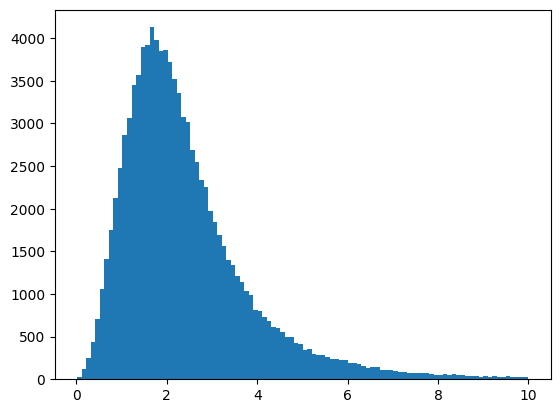

In [10]:
_ = plt.hist(z_dist, bins=100)

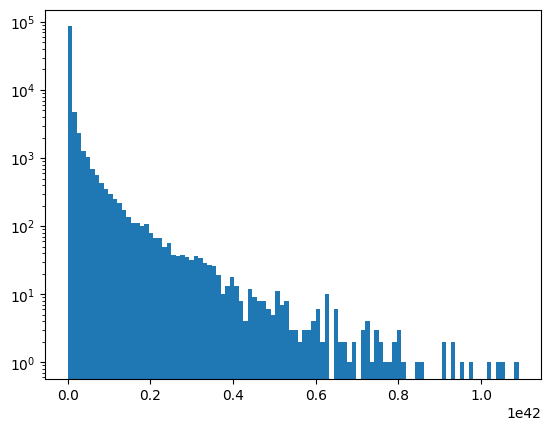

In [13]:
_ = plt.hist(frb_E, bins=100)
plt.yscale('log')

In [14]:
frb_emission_rate_z0

<Quantity 169677.22538852 1 / (Gpc3 yr)>

In [106]:
    lensed_galaxies = pd.read_csv(
        data_lensed_galaxies,
        delim_whitespace=True
    )

In [107]:
lensed_galaxies.shape[0]

169590

In [ ]:
# Distribution of lensing probability

In [ ]:
lensed_fraction_interp, lensed_fraction, z_mean = get_lensed_galaxy_fraction(
    zmin = 0,
    zmax = 4,
    frbs_evolve_with_luminosity = True,
)

In [ ]:
z = np.linspace(0, 4, 1000)
plt.plot(z, lensed_fraction_interp(z), 'r-')
plt.plot(z_mean, lensed_fraction, 'k-')

In [337]:
from scipy.spatial import KDTree

def get_magnified_images(
    hosts,
    sie_org = None
):
    """Magnification factors based on simulations of point sources in lensed galaxies."""
    # Load simulation results
    if sie_org is None:
        sie_org = pd.read_csv(data_sie_catalog, index_col=['q', 0])
        sie_org.index.names = ['q','id']
        sie_org.sort_index(inplace=True)
    sie = sie_org.loc[np.sort(hosts['q_l'].clip(0.01, 0.99).unique())]
    sie.sort_index(inplace=True)
    
    # Create a KD tree to find nearest point
    tree = KDTree(np.array([
        sie.index.get_level_values(0).to_numpy(),
        np.hypot(sie['RA'], sie['DEC']).to_numpy()
    ]).T)
    
    # Query KD tree for each host
    _, sie_idx = tree.query(np.array([
        hosts['q_l'].to_numpy(),
        frb_lens_dist_Er.value
    ]).T)
    
    return sie.iloc[sie_idx].sort_index()

In [338]:
frb_properties = FRB_Population(name='shin').get_parameters(uncertain = False)

(
    frb_dist_fact,
    z_min,
    z_max,
    frb_emission_rate,
    hosts,
    frb_dist_z
) = get_distribution_dist(
    int(1e4),
    frb_properties['alpha_spect'],
    frb_properties['alpha_rate'],
    frb_properties['frb_emission_rate_z0_Epivot'],
    frb_properties['n_sfr'],
    z_min = 0,
    z_max = 4,
    simulate_lensed_frbs = True,
    frbs_evolve_with_luminosity = True,
)

In [340]:
    hosts_sel = hosts
    frb_host_dist = (
        rng.exponential(size=hosts_sel.shape[0], scale=2) *
        hosts_sel['halflightradius_s(arcsec)'].to_numpy() *
        u.arcsec
    )
    frb_host_angle = rng.uniform(low=0, high=2*np.pi, size=hosts_sel.shape[0]) * u.rad
    # FRB coordinates in the lens refenrence in units of Einstein radius
    frb_host_x = frb_host_dist * np.cos(frb_host_angle)
    frb_host_y = frb_host_dist * np.sin(frb_host_angle)
    frb_lens_x = frb_host_x + hosts_sel['x_s_unlensed'].to_numpy() * u.arcsec
    frb_lens_y = frb_host_y + hosts_sel['y_s_unlensed'].to_numpy() * u.arcsec
    frb_lens_x_Er = frb_lens_x / hosts_sel['R_Ein(arcsec)'].to_numpy() / u.arcsec
    frb_lens_y_Er = frb_lens_y / hosts_sel['R_Ein(arcsec)'].to_numpy() / u.arcsec
    frb_lens_dist_Er = np.sqrt(frb_lens_x_Er**2 + frb_lens_y_Er**2)

In [341]:
sie = pd.read_csv(data_sie_catalog, index_col=['q', 0])
sie.index.names = ['q','id']
sie.sort_index(inplace=True)

In [407]:
from scipy.spatial import KDTree

tree = KDTree(list(map(list, zip(*[
    sie.index.get_level_values(0).to_numpy(),
    np.hypot(sie['RA'], sie['DEC']).to_numpy()
]))))

_, idx_sie = tree.query(list(map(list, zip(*[
    hosts['q_l'].to_numpy(),
    frb_lens_dist_Er.value
]))))

In [398]:
hosts['q_l'].iloc[100], frb_lens_dist_Er[100], d[100], frb_lens_dist_Er[100] - d[100]

(0.78, <Quantity 1.02670936>, 0.02670461990233397, <Quantity 1.00000474>)

In [393]:
sie.index.get_level_values(0)[idx_sie[100]], np.hypot(*sie.iloc[idx_sie[100]][['RA', 'DEC']].to_list())

(0.78, 1.0000047399887662)

In [391]:
sie.iloc[idx_sie[100]][['RA', 'DEC']].to_list()

[0.1532, 0.9882]

In [369]:
np.hypot(-0.1028, -0.4897) - 0.5

0.00037379028082595855

In [370]:
sie.index[42462]

(0.12, 42462)

In [367]:
sie.iloc[42462]

RA          -0.1028
DEC         -0.4897
N_images     2.0000
mu_tot       1.8261
tmax        28.8274
im1_RA      -0.1344
im1_DEC     -1.4687
mu_1         1.3087
t1           0.0000
im2_RA       0.3217
im2_DEC      0.1116
mu_2         0.5174
t2          28.8274
im3_RA       0.0000
im3_DEC      0.0000
mu_3         0.0000
t3           0.0000
im4_RA       0.0000
im4_DEC      0.0000
mu_4         0.0000
t4           0.0000
weights      0.5003
Name: (0.12, 42462), dtype: float64

In [12]:
import numpy as np
from scipy.spatial import KDTree
x, y = np.mgrid[0:5, 2:8]
tree = KDTree(np.c_[x.ravel(), y.ravel()])

In [13]:
tree.query([[0, 0], [2.2, 2.9]], k=1)

(array([2.       , 0.2236068]), array([ 0, 13]))

In [14]:
np.c_[x.ravel(), y.ravel()].shape

(30, 2)

In [15]:
np.array([
    sie.index.get_level_values(0).to_numpy(),
    np.hypot(sie['RA'], sie['DEC']).to_numpy()
]).shape

NameError: name 'sie' is not defined

In [11]:
#plt.plot(frb_lens_x_Er, frb_lens_y_Er, 'k.', zorder=0)

plt.scatter(a['RA'], a['DEC'], c=np.log10(a['mu_1']), zorder=5, marker='.')
plt.colorbar()

plt.xlim(-1, 1)
plt.ylim(-1, 1)

NameError: name 'a' is not defined

(-1.0, 1.0)

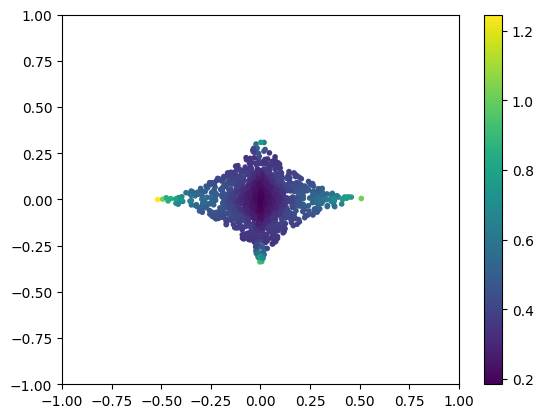

In [331]:
#plt.plot(frb_lens_x_Er, frb_lens_y_Er, 'k.', zorder=0)

plt.scatter(a['RA'], a['DEC'], c=np.log10(a['mu_`3']), zorder=5, marker='.')
plt.colorbar()

plt.xlim(-1, 1)
plt.ylim(-1, 1)

In [219]:
a

,RA,DEC,N_images,mu_tot,tmax,im1_RA,im1_DEC,mu_1,t1,im2_RA,...,t2,im3_RA,im3_DEC,mu_3,t3,im4_RA,im4_DEC,mu_4,t4,weights
id,,,,,,,,,,,,,,,,,,,,,
0,0.0473,0.4210,2,1.5937,12.6190,0.0527,0.9503,1.1197,0,-0.0614,...,12.6190,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4237
1,-0.0907,0.3725,2,1.2381,11.4988,-0.1018,0.9014,1.1244,0,0.0432,...,11.4988,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3834
2,-0.0298,0.0645,4,2.5145,4.7325,-0.0378,-0.4647,1.2738,0,-0.0357,...,-1.9124,-0.1857,-0.0013,0.0233,2.5601,0.1261,-0.0009,0.0156,2.8201,0.0710
3,-0.0729,-0.0477,4,2.5082,4.6593,-0.0914,0.4801,1.2620,0,-0.0878,...,-1.4110,-0.2289,0.0012,0.0264,2.6115,0.0831,0.0004,0.0094,3.2483,0.0871
4,-0.0013,-0.0202,4,2.5005,3.8946,-0.0016,0.5093,1.2443,0,-0.0016,...,-0.5987,-0.1573,0.0003,0.0163,3.2847,0.1548,0.0003,0.0161,3.2959,0.0202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2802,-0.0116,0.1524,4,2.6121,6.2271,-0.0157,-0.3770,1.3604,0,-0.0136,...,-4.5219,-0.1662,-0.0038,0.0432,1.6046,0.1430,-0.0032,0.0367,1.7052,0.1529
2803,-0.2073,-0.0680,3,2.5416,3.8793,-0.2597,0.4477,1.2891,0,-0.2466,...,-1.9738,-0.3631,0.0028,0.0480,1.9055,0.0000,0.0000,0.0000,0.0000,0.2182
2804,-0.1880,0.1418,3,2.6350,5.2498,-0.2468,-0.3700,1.3712,0,-0.2194,...,-4.1244,-0.3427,-0.0072,0.0868,1.1254,0.0000,0.0000,0.0000,0.0000,0.2355


In [ ]:
                parameters['frb_emission_rate_z0_Epivot'] = (
                    rng.choice(np.exp(samples_shin[:, 0])) / u.Gpc**3 / u.year
                )
                parameters['gamma'] = rng.choice(samples_shin[:, 1])
                parameters['Echar'] = rng.choice(np.exp(samples_shin[:, 2])) * u.erg
                parameters['n_sfr'] = rng.choice(samples_shin[:, 3])
                parameters['alpha_spect'] = rng.choice(samples_shin[:, 4])

In [456]:
a = rng.choice(samples_shin[:, 4], 1000)

In [460]:
a = pd.DataFrame()
a['FRB_rate_z0_E>1e39 (1/Gp3/yr)'] = rng.choice(np.exp(samples_shin[:, 0]), 1000)
a['gamma'] = rng.choice(samples_shin[:, 1], 1000)
a['Echar'] = rng.choice(np.exp(samples_shin[:, 2]), 1000)
a['n_sfr'] = rng.choice(samples_shin[:, 3], 1000)
a['alpha'] = rng.choice(samples_shin[:, 4], 1000)

In [467]:
a.to_csv('/arc/home/michilli/paramters_error_distribution.csv', index=False)

In [463]:
np.median(samples_shin[:, 0])

11.19392598414439

In [464]:
np.median(np.exp(samples_shin[:, 0]))

72687.59272105762

In [16]:
1e39*u.erg/400/u.MHz

<Quantity 2.5e+36 erg / MHz>

In [18]:
(4*np.pi*cosmo.luminosity_distance(0.5)**2*1*u.ms/(1+0.5)**(-1.39+2)*0.35*u.Jy).to(u.erg/u.MHz)

<Quantity 2.78751661e+36 erg / MHz>

In [29]:
z, P_z = np.loadtxt('../lensprob.txt')
z = z[::10]
P_z = P_z[::10]

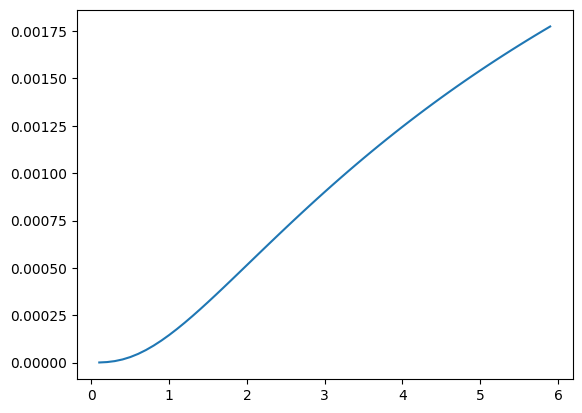

In [30]:
plt.plot(z, P_z)

In [24]:
# Redshift distribution of detected FRBs

# CHIME
chime_z_dist = run_simulation(
    int(1e5),
    telescope_name = 'chime',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

# CHORD
chord_z_dist = run_simulation(
    int(1e5),
    telescope_name = 'chord',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

# DSA-2000
dsa_z_dist = run_simulation(
    int(1e5),
    telescope_name = 'dsa2000',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

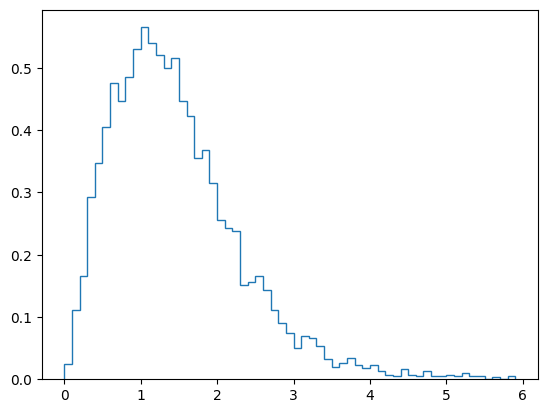

In [40]:
chord_hist, bins = np.histogram(chord_z_dist, bins=np.insert(z, 0, 0), density=True)
plt.stairs(chord_hist, bins)

In [72]:
# Without scattering
telescope_name = 'chord'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    int(1e5),
    telescope_name = telescope_name,
    simulate_lensed_frbs = False,
)

print(np.sum(chord_hist * P_z) * np.diff(z)[0] * frb_detection_rate)
print(np.sum(chord_hist * P_z) * np.diff(z)[0] * frb_detection_rate_low, np.sum(chord_hist * P_z) * np.diff(z)[0] * frb_detection_rate_high)

4.841564921187521 1 / yr
1.6675916977022294 1 / yr 24.596100269054812 1 / yr


In [74]:
# With scattering
telescope_name = 'chord'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    int(1e5),
    telescope_name = telescope_name,
    simulate_lensed_frbs = False,
)

print(np.sum(chord_hist * P_z) * np.diff(z)[0] * frb_detection_rate)
print(np.sum(chord_hist * P_z) * np.diff(z)[0] * frb_detection_rate_low, np.sum(chord_hist * P_z) * np.diff(z)[0] * frb_detection_rate_high)

2.023666400682493 1 / yr
0.9157377103115725 1 / yr 9.832781549749637 1 / yr


In [56]:
# Without scattering

chime_hist, bins = np.histogram(chord_z_dist, bins=np.insert(z, 0, 0), density=True)
telescope_name = 'chime'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    int(1e5),
    telescope_name = telescope_name,
    simulate_lensed_frbs = False,
)

print(np.sum(chime_hist * P_z) * np.diff(z)[0] * frb_detection_rate)
print(np.sum(chime_hist * P_z) * np.diff(z)[0] * frb_detection_rate_low, np.sum(chime_hist * P_z) * np.diff(z)[0] * frb_detection_rate_high)

0.28792206055254377 1 / yr
0.019533553294220178 1 / yr 1.5917451393421287 1 / yr


In [71]:
0.28792206055254377 * 5, 0.019533553294220178 * 5, 1.5917451393421287 * 5

(1.439610302762719, 0.0976677664711009, 7.958725696710643)

In [67]:
# With scattering

chime_hist, bins = np.histogram(chord_z_dist, bins=np.insert(z, 0, 0), density=True)
telescope_name = 'chime'
(
    frb_detection_rate,
    frb_detection_rate_low,
    frb_detection_rate_high,
    uncert_med
)= run_simulation_with_uncert(
    int(1e5),
    telescope_name = telescope_name,
    simulate_lensed_frbs = False,
)

print(np.sum(chime_hist * P_z) * np.diff(z)[0] * frb_detection_rate)
print(np.sum(chime_hist * P_z) * np.diff(z)[0] * frb_detection_rate_low, np.sum(chime_hist * P_z) * np.diff(z)[0] * frb_detection_rate_high)

0.06697173505770292 1 / yr
0.014751217971396608 1 / yr 0.3968750257445703 1 / yr
1.7254139723150914


In [70]:
0.06697173505770292 * 5, 0.014751217971396608 * 5, 0.3968750257445703 * 5

(0.3348586752885146, 0.07375608985698304, 1.9843751287228515)

In [8]:
cosmo.comoving_distance(0.5)

<Quantity 1946.41663479 Mpc>

In [9]:
cosmo.comoving_distance(0.5/np.cos(u.microarcsecond.to(u.rad)))

<Quantity 1946.41663479 Mpc>

In [17]:
import mpmath

In [22]:
u.microarcsecond.to(u.rad)

4.84813681109536e-12

In [34]:
mpmath.cos(u.microarcsecond.to(u.rad))

mpf('1.0')

In [32]:
np.cos(1e10)

0.873119622676856

In [6]:
cosmo.kpc_comoving_per_arcmin(1)

<Quantity 987.7500286 kpc / arcmin>

In [46]:
(cosmo.kpc_comoving_per_arcmin(1) * u.microarcsecond).to(u.m) * np.sin(u.microarcsecond.to(u.rad)) / const.c

<Quantity 8.21486649e-06 s>

In [10]:
x = 0.1
(cosmo.kpc_comoving_per_arcmin(.5) * x * u.microarcsecond).to(u.m) * np.sin(x * u.microarcsecond.to(u.rad)) / const.c

<Quantity 4.70885572e-08 s>

In [5]:
(cosmo.kpc_comoving_per_arcmin(1) * u.milliarcsecond).to(u.m) * np.sin(u.milliarcsecond.to(u.rad)) / const.c

<Quantity 8.21486649 s>

In [16]:
(100 * u.ns * const.c).to(u.km)

<Quantity 0.02997925 km>

In [55]:
# DSA2000 detection of M81's pulsars

sn = 8
Srec = 2.5 * u.Jy
t = np.array([1, 3, 5, 8]) * u.hr
f = (2000 - 700) * u.MHz

dc = np.logspace(-3, np.log10(5e-1), 100)

(0.001, 0.5)

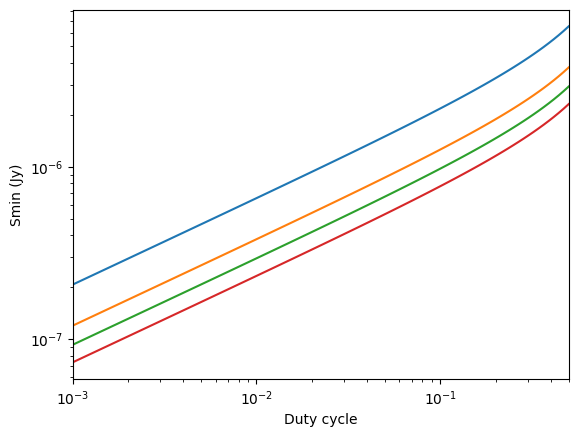

In [56]:
for ti in t:
    S = (sn * Srec / np.sqrt(2 * ti * f) * np.sqrt(dc / (1 - dc))).to(u.Jy)
    plt.plot(dc, S)

plt.xlabel('Duty cycle')
plt.ylabel('Smin (Jy)')
plt.loglog()
plt.xlim(1e-3, 5e-1)

In [57]:
pulsar_lum14 = np.array([9.46, 83.8, 10.6, 7.15, 8.99, 43.8, 0.382, 11.8, 3.51, 228, 891, 0.781, 12.2, 7.5, 0.0617, 4.07, 1.57, 157, 674, 0.938, 1.9, 210, 1.07, 2440, 0.116, 31.1, 23.8, 9.51, 1000, 1.78, 6.06, 0.461, 1.27, 0.696, 2.18, 14.9, 8.93, 0.924, 54.8, 0.00971, 11.5, 8.25, 0.816, 0.996, 583, 4.76, 3.3, 0.872, 0.352, 2.95, 24.2, 23, 3.91, 57.9, 0.626, 0.936, 2.41, 0.612, 0.555, 3.69, 6.54, 138, 3.78, 124, 2.69, 18.1, 205, 32.1, 0.0533, 0.0154, 4.35, 0.207, 0.0116, 321, 4.53, 205, 2470, 6.58, 13.1, 6.13, 526, 104, 3.3, 56, 287, 0.178, 3.21, 0.687, 247, 0.0898, 26.2, 215, 143, 0.838, 11.3, 0.382, 6.9, 0.716, 1.14, 1.37, 0.0045, 42.1, 0.27, 2.89, 0.311, 0.51, 5.26, 6.08, 7.28, 0.182, 31.2, 1.82, 3.27, 4.92, 2.7, 0.0147, 0.51, 0.431, 22.6, 1.28, 2.2, 2.21, 7.9, 0.0554, 0.688, 0.224, 0.0512, 0.37, 0.0413, 0.0546, 0.0292, 77, 1.96, 2.55, 1.68, 5.97, 7.6, 1.19, 4.4, 3.7, 1.57, 288, 1.45, 104, 1.6, 0.131, 0.157, 0.194, 1.66, 1.29, 19.1, 0.0683, 2.47, 0.315, 1.75, 109, 13, 1.87, 0.0588, 0.328, 21.7, 8.17, 5.12, 1.63, 26.9, 25, 2.48, 0.0313, 14.9, 8.49, 0.0862, 82.3, 1.68, 0.18, 78.8, 8.41, 2.86, 0.545, 10.3, 1.73, 1.43, 0.147, 0.152, 8.9, 43.4, 0.452, 7.87, 3.04, 4.69, 0.0627, 0.273, 2.2, 9.33, 1.86, 0.0387, 1.98, 2.59, 20, 1.07, 0.012, 0.0252, 0.0238, 0.503, 12.1, 3.79, 0.289, 0.0687, 0.0714, 7.2, 0.0514, 0.0193, 0.0843, 0.39, 0.0938, 0.0792, 0.99, 0.165, 2.87, 4.93, 0.282, 0.0483, 81.2, 0.844, 1.09, 6.81, 0.0956, 0.151, 0.0363, 0.521, 0.00419, 0.9, 0.261, 0.231, 1.28, 1.71, 0.195, 0.675, 0.13, 1.86, 0.627, 19.4, 25.7, 22.4, 0.0151, 2.41, 9, 27.2, 3.56, 438, 453, 0.176, 2.68, 2.18, 1.62, 3.6, 2.23, 0.486, 1.37, 0.835, 9.93, 21.4, 1.13, 4.28, 1.26, 2.65, 1.93, 14.8, 4.82, 13, 0.317, 6.74, 7.5, 5.06, 9.66, 76.5, 6.32, 1.45, 0.437, 2.07, 1.08, 1.37, 2.59, 13.9, 0.425, 1.24, 1.03, 196, 1.43, 0.216, 0.0381, 1.24, 4.02, 5.41, 1.43, 1.12, 0.961, 0.423, 0.00305, 6.68, 0.881, 0.00238, 1.1, 3.28, 19.7, 45.8, 10.9, 2.59, 161, 0.248, 2.56, 2.29, 0.47, 25.3, 1.06, 76.9, 0.464, 8.1, 3.45, 13.4, 2.44, 1.68, 2.16, 2, 1.39, 3.04, 1.29, 0.897, 8.24, 0.421, 14.8, 1.04, 0.684, 2.14, 3.54, 0.763, 388, 2.76, 13.8, 0.535, 10.2, 29.4, 0.49, 5.49, 240, 3.15, 1.72, 0.986, 0.876, 1.4, 8.54, 1.77, 0.511, 0.361, 0.298, 0.558, 0.318, 0.129, 2.19, 0.255, 224, 1.95, 1.81, 11.8, 10.7, 1.82, 2.15, 7.15, 13.8, 0.145, 29.2, 0.496, 5.36, 77.2, 1.39, 54.4, 0.218, 8.58, 22.4, 142, 1.12, 1.25, 122, 24.4, 0.0512, 6.56, 103, 1.81, 10, 25.1, 7.54, 3.03, 17, 4.55, 3.69, 16.4, 2.38, 1.7, 28, 137, 0.235, 2.34, 10.8, 20.1, 13.9, 2.37, 22.9, 5.34, 2.62, 0.692, 35.3, 11, 0.352, 3.03, 50.7, 750, 3.22, 0.196, 28.8, 56.3, 0.234, 62.5, 23.1, 31.2, 37.8, 89.9, 200, 297, 46.4, 18.3, 1240, 163, 8.77, 30.1, 19, 312, 18.8, 53.3, 1.75, 29.9, 462, 261, 183, 124, 3.58, 10.2, 119, 1.06, 55.4, 26, 456, 31.4, 162, 273, 610, 119, 336, 162, 35.4, 8.92, 57.8, 31, 23.9, 0.233, 0.617, 3.86, 1.68, 938, 18.4, 9.67, 902, 1.03, 12.3, 1.77, 33.4, 429, 0.725, 1.45, 0.622, 1.04, 7.84, 10.4, 18.3, 3.2, 26.5, 57.7, 22.8, 13.9, 98, 6.39, 21.2, 14.9, 28.6, 30.7, 48.2, 554, 5, 0.972, 312, 0.0131, 23, 20.9, 22.5, 1.34, 15.3, 10.6, 26, 23.4, 12.4, 24.2, 23, 347, 2.14, 12.3, 34.8, 58.8, 164, 11.1, 19.1, 54.4, 0.202, 18.1, 15.8, 6.79, 15.3, 0.213, 37.7, 5.48, 8.01, 14.6, 58.3, 8.87, 0.272, 5.25, 8.92, 4.21, 27.6, 6.5, 1.4, 28.7, 4.53, 8.36, 8.9, 1.75, 6.73, 3.24, 1.81, 2.48, 5.47, 4.34, 0.163, 9.26, 2.26, 5.32, 6.21, 1.13, 4.87, 6.69, 71.5, 0.258, 141, 2.67, 0.342, 11.8, 1.37, 3.35, 10.5, 5.12, 6.12, 25.2, 15.1, 53.8, 3.02, 14, 7.18, 1.75, 6.95, 13.8, 35.3, 2.39, 20.9, 4.43, 13.1, 9.94, 364, 26.7, 27.7, 12.6, 2.01, 0.106, 4.42, 9.21, 10, 17.7, 6.71, 1.4, 2.18, 0.448, 0.56, 136, 3.72, 1.14, 20.8, 4.84, 48.9, 1, 90.4, 12.8, 14.6, 24.9, 5.12, 4.29, 2.06, 4.2, 6.45, 2.53, 24.3, 0.24, 17.8, 1.4, 4.99, 14.4, 1.54, 1.16, 48.5, 36.3, 7.02, 2.3, 3.66, 1.97, 65.1, 4.46, 19.7, 22.3, 2.65, 3.09, 110, 19.7, 14.6, 0.407, 1.31, 0.527, 4.28, 71.7, 2.43, 14.8, 11.8, 1.54, 13.9, 4.11, 0.381, 2.4, 3.38, 62.5, 9.67, 7.99, 2.24, 4.45, 10.1, 20.8, 205, 5.74, 1.08, 17.6, 2.7, 5.06, 5.28, 9.1, 4.36, 2.49, 2.76, 13.3, 6.03, 8.54, 45.2, 2.74, 0.817, 10.2, 19.2, 4.96, 24.9, 4.75, 3.17, 12.9, 4.5, 12.6, 119, 13.4, 234, 13, 22.1, 2.1, 196, 12.3, 8.69, 1000, 43.7, 10.6, 2.17, 3.2, 6.18, 527, 58, 9.04, 15.1, 2.42, 42.1, 33.7, 3.12, 0.376, 63.4, 5.69, 17.9, 2.01, 6.81, 2.61, 0.962, 5.34, 11.3, 11.7, 50.4, 21.8, 1.93, 30.4, 12.6, 0.676, 3.84, 6.34, 3.67, 8.95, 5.27, 9.21, 17.4, 6.46, 15.4, 1.59, 0.559, 5.78, 79.4, 109, 6.01, 8.49, 2.42, 27.9, 8.15, 2.06, 56.2, 15.9, 14.9, 18.4, 6.07, 19.2, 2.12, 9.54, 0.509, 5.52, 11.2, 28.9, 50.5, 4.57, 26, 2.7, 15.2, 7.2, 1.67, 5.48, 1210, 4.05, 5.37, 8.91, 4.76, 5.51, 5.61, 29.7, 20.6, 2.91, 7.39, 11.4, 3.99, 1.12, 16.6, 18.4, 56.9, 13.1, 3.58, 11.9, 0.937, 11.8, 13.5, 252, 22.2, 15.8, 21.2, 79.8, 11.9, 13.5, 605, 8.76, 274, 56.9, 17.8, 2.6, 8.95, 1.04, 2.37, 15, 21.7, 93.7, 11.7, 45, 24.9, 47.1, 112, 52.2, 17.8, 18.1, 8.19, 40.1, 244, 45.3, 172, 3.82, 23.3, 43.4, 9.4, 7.2, 10.7, 22, 14.3, 1.06, 5.19, 37.6, 14, 1.62, 7.71, 1.21, 1.65, 1.32, 0.551, 2.07, 10.1, 2.34, 6.52, 6080, 26.9, 381, 0.547, 86.2, 48.5, 20.5, 7.6, 56.9, 31.7, 16.7, 12.2, 21.7, 137, 9.06, 14.6, 9.12, 59.5, 189, 1.22, 6.88, 7.42, 9.36, 8.17, 0.21, 579, 13.8, 162, 91.8, 7.91, 0.143, 16.3, 59.2, 118, 52.9, 30, 8.5, 41.5, 7.33, 79.5, 15.3, 15.7, 250, 90.6, 33.4, 7.89, 22.1, 98.8, 59.7, 0.189, 5.22, 67.6, 0.0165, 87.3, 69, 31.1, 5.83, 12.1, 40.4, 687, 1190, 30.5, 69.2, 18.4, 11.1, 11.7, 17.2, 47.3, 5.71, 87.3, 5.73, 23.7, 31.1, 54.4, 3.16, 78.3, 30.9, 18.8, 46.3, 4.74, 12.4, 62.3, 86.3, 71.9, 163, 77.8, 395, 43, 16, 15.4, 178, 117, 1.31, 4.58, 0.902, 150, 5.73, 5.82, 16.9, 81.8, 24.3, 3.71, 16, 0.818, 2.75, 4.13, 16.9, 14.3, 5.09, 5.28, 0.0231, 1.31, 9.3, 14.4, 9.22, 29.2, 24.7, 11.8, 52.5, 4.23, 144, 2440, 13, 7.54, 64.1, 110, 113, 58.3, 63, 6.52, 6.14, 20.7, 9.41, 15.2, 0.0485, 2.92, 134, 66.8, 5.56, 1.07, 2.03, 1.14, 11.3, 19.2, 1.13, 355, 46.3, 46.2, 23.3, 18.1, 0.948, 2.96, 25.7, 3.75, 115, 11, 2.71, 0.00453, 4.52, 14, 2.4, 6.78, 8.7, 6.81, 18.6, 26.6, 0.938, 15.1, 1.39, 3.95, 57.2, 0.188, 1.54, 18.9, 52.3, 4.55, 0.625, 8.69, 15.4, 3.08, 13.2, 2.08, 4.51, 2.12, 37.1, 57.6, 29.2, 7.4, 5.14, 14.5, 1.57, 85, 14.4, 35.7, 181, 5.33, 0.902, 3.42, 16.8, 1.54, 14.1, 123, 8.66, 16.9, 5.78, 46.6, 1.24, 0.0454, 7.78, 15.2, 62.7, 6.2, 0.735, 8.42, 7.49, 24.4, 2.87, 5.97, 3.9, 7.76, 500, 0.486, 38.1, 9.54, 9.59, 136, 20.2, 0.0738, 4.06, 36.6, 36.3, 1.42, 15.8, 5.27, 17.9, 0.806, 0.0144, 26.7, 16.8, 8.28, 38.9, 4.14, 117, 20.2, 48.5, 0.02, 6.11, 5.9, 23.3, 46.7, 0.804, 47.7, 0.406, 1.48, 7.64, 2.27, 30.9, 0.0194, 31.5, 2.55, 0.84, 5.07, 27, 25.2, 58, 13.3, 1.59, 11.5, 25.2, 5.03, 26.7, 1.97, 48.2, 30.6, 20.8, 12.3, 665, 0.392, 3.45, 3.95, 18.8, 82.5, 6.37, 1.49, 26.3, 27.2, 5.9, 0.545, 341, 3.6, 72.3, 1.91, 9.46, 1.1, 1.57, 64.8, 2.4, 25.4, 3.07, 62.5, 2.77, 45.9, 8.3, 4.34, 3.29, 4.78, 2.18, 3.66, 35, 8.75, 5.71, 0.579, 29.4, 4.55, 2.61, 1.6, 54.3, 13.9, 70.3, 4.72, 1.04, 7.85, 93.1, 7.56, 7.76, 0.805, 2.9, 76.1, 57.4, 8.75, 13.8, 43.5, 20, 11.9, 14.1, 3.27, 8.75, 0.0354, 2.2, 0.327, 77.9, 23.1, 1.88, 189, 12, 42, 3.59, 112, 21.1, 23.6, 16.8, 3.85, 2.48, 9.14, 0.424, 99.5, 37.4, 58, 46.5, 42.4, 186, 14.4, 66.6, 3.29, 0.259, 12, 26.5, 108, 31.4, 8.44, 5.65, 4.21, 24.4, 22.7, 229, 19.1, 40.9, 7.32, 215, 25.2, 15, 6.49, 78.2, 54.6, 1.1, 66.8, 58.8, 177, 4.36, 29.9, 8.81, 24.6, 14.3, 9.58, 94.8, 12.6, 16.4, 86.4, 5.37, 25.4, 10.2, 4.46, 3.67, 0.838, 15.5, 14.7, 96.9, 9.82, 292, 89.1, 134, 32.7, 5.82, 26.6, 20.8, 35.2, 18.3, 9.55, 12.1, 1.69, 23.4, 25.5, 30.7, 0.00951, 23.2, 61.5, 77.4, 33, 84.6, 284, 4.74, 60.4, 23, 5.88, 4.62, 138, 64.2, 35.9, 40.3, 18, 0.105, 40.3, 10.2, 0.495, 5.97, 82.2, 2.72, 68.7, 22.4, 296, 0.861, 1.9, 11.4, 7.51, 4.53, 0.586, 31, 10.3, 18.1, 44.2, 40.4, 12.2, 21.7, 6.8, 92.3, 43.9, 14.1, 31.3, 40.2, 46.3, 4.5, 14.1, 2.91, 1.15, 46.8, 13.9, 1.76, 16.5, 5.91, 107, 4.65, 25.7, 66.3, 1.39, 2.73, 0.918, 0.983, 57.2, 11.2, 61.1, 102, 3.71, 280, 4.8, 55.8, 220, 3.38, 4.39, 52.3, 7.41, 16.4, 123, 10.2, 16.7, 6.1, 385, 0.0306, 4.2, 4.29, 1.17, 14.9, 15.5, 41.5, 10.2, 15.1, 4.75, 28.5, 19.9, 19.5, 0.176, 73.6, 108, 3.99, 41.7, 10.7, 17.5, 17.6, 28, 140, 1.19, 29.6, 2.6, 3.26, 3.72, 122, 32.2, 19.5, 21.6, 8.43, 4, 26.2, 8.12, 25.7, 4.46, 4.86, 17.8, 58.1, 15.1, 14, 10.7, 2.38, 16.1, 24.9, 23, 38, 10.4, 137, 4.42, 1.32, 4.95, 6.14, 10.8, 17.1, 59.9, 5.49, 21.8, 11.6, 4.18, 1.86, 17.6, 6.93, 3.31, 8.55, 4.08, 16.6, 3.76, 4.62, 4.67, 1.86, 36.9, 10.2, 5.85, 2.39, 7.68, 5.53, 5.25, 75.5, 82.4, 33.4, 51.1, 13, 25.5, 8.4, 1.07, 50.9, 2.61, 29.5, 63.9, 3.4, 4.71, 36.3, 2.42, 28.4, 6.47, 18.6, 1.69, 60.6, 4.55, 17.7, 53.5, 1.56, 98.1, 41.3, 42.3, 16.5, 2.32, 15.3, 32.7, 29.9, 2.7, 45.4, 1.16, 4.96, 8.46, 6.7, 0.159, 5.86, 24.6, 405, 45.5, 26.3, 21.5, 3.32, 18.9, 10.4, 6.14, 8.38, 93.5, 5.1, 8.97, 48.9, 14.1, 7.98, 31.9, 152, 8.29, 23.4, 27.8, 5.43, 68.5, 3.38, 2.8, 1810, 11.1, 57.3, 9.58, 11.6, 15, 0.799, 10.4, 294, 0.222, 9.14, 31, 59.1, 55.6, 0.216, 1.64, 6.7, 16.6, 0.284, 12.4, 0.462, 10.1, 1.03, 1.22, 3.93, 7.24, 20.7, 28, 24.5, 79.7, 9.72, 13.5, 3.76, 13.1, 0.736, 7.61, 3.19, 12.8, 6.92, 12.6, 11, 4.61, 5.24, 3.84, 5.78, 9.34, 0.713, 326, 1.98, 7.82, 18.8, 32.7, 199, 8.47, 20, 6.76, 1.3, 3.1, 7.45, 24.5, 91.6, 115, 0.877, 23, 2.17, 1.58, 5.7, 15.4, 197, 9.57, 1.93, 34.2, 53.9, 32.9, 11.3, 10.7, 35.2, 16.3, 2.07, 0.108, 23.2, 18.5, 6.51, 3.7, 5.8, 15.4, 15.8, 102, 2.22, 98.7, 24.2, 7.2, 33.3, 11.5, 4.81, 2.65, 1.37, 5.73, 287, 3.52, 12.2, 13, 8.05, 4.76, 6.73, 5.86, 17.7, 37.8, 7.35, 5.34, 18.3, 13.1, 3.96, 7.92, 10.7, 3.28, 6.42, 30.8, 206, 6.7, 34.2, 323, 17.5, 23.1, 1.7, 4.07, 10.4, 12.9, 0.24, 1.47, 6.1, 3.61, 15.6, 78.4, 1.88, 2.16, 23.1, 59.9, 2.32, 4.16, 0.276, 9.01, 3.86, 12.6, 7.83, 117, 0.81, 2.53, 4.82, 8.71, 43.3, 17.5, 15.9, 106, 40.9, 1.32, 0.0566, 32.5, 12.5, 47.1, 12.9, 1.91, 23.3, 0.72, 0.669, 137, 7.4, 2.16, 30.1, 17.6, 35.2, 8.93, 15.3, 50.4, 2.89, 8.73, 13.8, 6.91, 1.74, 13.5, 8.89, 10.9, 118, 27, 5.63, 0.242, 25.6, 33.5, 17.4, 7.11, 1.04, 16.5, 12.8, 30.2, 0.197, 15.5, 23.2, 73.7, 4.57, 10.3, 2.34, 4.6, 37.7, 115, 12.3, 11.5, 60.7, 185, 3.8, 1.14, 4.87, 33.8, 6.92, 14.4, 18.5, 1.48, 3.57, 0.851, 4.08, 0.851, 1.19, 4.65, 5.97, 5.22, 1.14, 6.93, 7.82, 1.68, 3.8, 9.08, 111, 9.03, 6.48, 2.06, 1.28, 60.6, 3.59, 2.63, 31.2, 19.2, 1.78, 18.2, 82.1, 33.2, 21.9, 331, 4.17, 0.82, 18.2, 18.2, 5.42, 2.42, 41.6, 3.23, 0.67, 2.67, 34.1, 98, 4.6, 9.22, 6.81, 15.6, 388, 53.1, 11.5, 5.8, 22.3, 14.6, 3.95, 24.3, 0.47, 235, 1.44, 8.87, 0.716, 2.07, 1.7, 27.7, 434, 38, 4.69, 3.18, 21.2, 7.65, 58.7, 15.6, 12.6, 5.54, 2.19, 5.37, 17.2, 1.25, 1.17, 31.8, 1.69, 14.3, 33.2, 22.4, 0.168, 6.45, 0.291, 12.1, 8.92, 5.3, 4.28, 2.88, 1.78, 28.2, 8.37, 15.3, 0.143, 46.8, 2.75, 4.32, 19.1, 13.1, 5.29, 22.6, 2.96, 1.61, 19.4, 5.25, 71.6, 50, 18.4, 1.62, 7.23, 1.77, 2.02, 2.94, 1.1, 0.377, 3, 5.79, 13.7, 11.7, 2.76, 1.54, 0.157, 30, 143, 31.6, 15.5, 0.401, 1.31, 9.24, 12.1, 794, 3.61, 3.76, 2.75, 10.6, 1.12, 5.41, 1.79, 13.7, 4.47, 8, 7.08, 5.88, 170, 1.08, 0.795, 9.8, 4.95, 5.07, 29.8, 24.1, 13.3, 7.48, 1.74, 3.12, 5.09, 8.01, 9.02, 7.5, 0.9, 6.35, 33.1, 4.88, 5.31, 3.66, 10.3, 18.1, 47.1, 5.61, 486, 6.37, 0.438, 8.61, 18.4, 2.2, 8.55, 1.29, 9, 0.944, 6.04, 2.68, 1.74, 3.59, 2.3, 38.9, 4.09, 19.1, 10, 47.5, 1.69, 0.568, 4.47, 9.95, 50, 200, 11.1, 3.53, 115, 2.36, 46, 32.5, 9.83, 117, 5.82, 2.2, 8, 4.16, 18.6, 4.16, 20, 28.4, 2.95, 325, 28.8, 10.6, 0.352, 0.324, 168, 87.5, 9.32, 109, 20, 6.82, 18.8, 3.86, 20.1, 1.45, 66.4, 17.7, 5.65, 19.9, 1.7, 6.04, 175, 0.0131, 6.35, 65, 7.54, 102, 2.24, 89.8, 500, 0.756, 21.5, 22.9, 9.93, 3.03, 0.0205, 2.81, 22.4, 1.87, 26.1, 1.11, 0.393, 143, 6.12, 13.4, 3.67, 562, 0.191, 4.9, 17.1, 0.0647, 1.62, 2.59, 2.25, 7.27, 1.21, 143, 1.99, 1.61, 8, 0.271, 3.17, 82.8, 1.04, 41.6, 8.18, 16.9, 1.67, 3.46, 12.7, 87.5, 0.348, 0.011, 90, 1.46, 49.5, 32.9, 2.15, 3.5, 0.686, 27.4, 29.7])
pulsar_dc = np.array([0.07149195736, 0.01028463816, 0.1153378496, 0.05655095185, 0.09947643979, 0.02544305467, 0.3462972829, 0.05620652611, 0.01091014778, 0.03162875433, 0.02159183656, 0.03100932535, 0.03451257605, 0.05341943967, 0.03714871249, 0.01752800586, 0.01120324745, 0.02178516343, 0.01380863684, 0.04041837952, 0.1822633297, 0.01263917455, 0.009709282506, 0.01825323812, 0.02027776025, 0.01908600079, 0.02853757597, 0.0356558901, 0.08329549761, 0.01921363399, 0.01420222005, 0.03499908698, 0.009832670157, 0.03898516058, 0.03453901048, 0.07469756595, 0.4433921653, 0.02317939488, 0.119763789, 0.006598576832, 0.01652863027, 0.03315114616, 0.01408277904, 0.1336818965, 0.009236970274, 0.02265964837, 0.01463211588, 0.02321039578, 0.01394772946, 0.0766812361, 0.06344211541, 0.02493861265, 0.03851416037, 0.03094642232, 0.2062096335, 0.01126140537, 0.01156706957, 0.01517656305, 0.1624376684, 0.02449192288, 0.02442013285, 0.01565226102, 0.05250973713, 0.0224074572, 0.04918579296, 0.02377255825, 0.008738448863, 0.009998350272, 0.01441723148, 0.008737277994, 0.0355484563, 0.03725990648, 0.1214208943, 0.01367718797, 0.04138353432, 0.02223764032, 0.3100775194, 0.03949915077, 0.04055491079, 0.01726579457, 0.0225470593, 0.01369131986, 0.01557603285, 0.08984187829, 0.008802986413, 0.0481596589, 0.01886028025, 0.01716669432, 0.335772197, 0.03032624036, 0.02154690517, 0.07475802379, 0.01328762391, 0.01512270009, 0.04293265382, 0.01797334658, 0.1476301476, 0.0628863348, 0.01778630924, 0.1508817766, 0.01776491526, 0.01940530213, 0.114322007, 0.009631270513, 0.02391349553, 0.03059827946, 0.004908206907, 0.009811758527, 0.01071687488, 0.007813626481, 0.02307903731, 0.007787532601, 0.05062603512, 0.02328005559, 0.01752115064, 0.008565970824, 0.0592540955, 0.02936857562, 0.02433862551, 0.007774198407, 0.02272594459, 0.01144559513, 0.01306384792, 0.03112084168, 0.02249265483, 0.03896822531, 0.03066371614, 0.08713584478, 0.009685369734, 0.01894422983, 0.1988708796, 0.01436302547, 0.02380645992, 0.00683460952, 0.02236871308, 0.03019959548, 0.02744237102, 0.01002087683, 0.01654357828, 0.6299836997, 0.02091249886, 0.06668071407, 0.08662508663, 0.02638490783, 0.0498047375, 0.01361506973, 0.01369297788, 0.2059623084, 0.2012072435, 0.008458424417, 0.01069965483, 0.01437181514, 0.01459862673, 0.02088697488, 0.01269696162, 0.01553356896, 0.07666868354, 0.03203736764, 0.06022976345, 0.005089626, 0.01857640151, 0.04806267373, 0.04284781481, 0.2585040499, 0.01083866024, 0.02312478248, 0.01092976495, 0.06111679311, 0.01764664361, 0.03880513219, 0.007757607997, 0.01903098692, 0.018958989, 0.02041188034, 0.005853983037, 0.02527699372, 0.03345176432, 0.03191722614, 0.01070839942, 0.02632133081, 0.0170235947, 0.01549110892, 0.01498971232, 0.07884240794, 0.01460686662, 0.02077898331, 0.0293770235, 0.07200720072, 0.008823629227, 0.02574536621, 0.009739186654, 0.03275383311, 0.03237945483, 0.02339005663, 0.01848298685, 0.05127032079, 0.02141295633, 0.02247843475, 0.009538554102, 0.02424504533, 0.02136443118, 0.08161157025, 0.02423478661, 0.01161097655, 0.002946472073, 0.005895452195, 0.05814700374, 0.01837538014, 0.09702457956, 0.006937157122, 0.01570981378, 0.02103753622, 0.01661156012, 0.03198355132, 0.02581397538, 0.01459988049, 0.005815651279, 0.05057852638, 0.01857498006, 0.01367787551, 0.01357113992, 0.03760220161, 0.007812304692, 0.02256490139, 0.03398336396, 0.02326314209, 0.004871700293, 0.01572041246, 0.1462498843, 0.01760033167, 0.006821515058, 0.007825776543, 0.003879156516, 0.03215429948, 0.02102344956, 0.02149319057, 0.02392925555, 0.01548882124, 0.1617199391, 0.008905174422, 0.01073267588, 0.0108376364, 0.328848601, 0.01078501948, 0.0330168272, 0.08380980761, 0.006753227149, 0.02565198803, 0.0205020793, 0.2892325491, 0.01372844332, 0.09965760494, 0.08507132559, 0.05907737191, 0.02190146046, 0.1009298721, 0.001094055994, 0.03035139078, 0.008722299431, 0.04308367064, 0.2155415917, 0.01276793247, 0.005878099963, 0.01761942786, 0.07278524886, 0.02416947637, 0.03606546025, 0.02135169921, 0.01663172849, 0.1123896173, 0.009194810449, 0.02246716546, 0.06054588167, 0.009574151806, 0.06223479491, 0.01453009887, 0.01273589085, 0.01667404841, 0.006918240807, 0.02934426517, 0.01086954159, 0.02448398937, 0.03712585665, 0.01671737604, 0.01472906905, 0.02958221044, 0.04024135344, 0.1900418092, 0.03183162344, 0.0659513482, 0.01781202965, 0.02596264624, 0.01434595524, 0.1056958309, 0.04126142057, 0.0115989682, 0.01459568181, 0.03732996878, 0.04904908073, 0.009934016058, 0.0367919042, 0.02525500633, 0.01444929298, 0.03761728532, 0.169329762, 0.04188932839, 0.03168845858, 0.03632821635, 0.01296824915, 0.01002149187, 0.01655253119, 0.01166294513, 0.009701106916, 0.05280141819, 0.06373126975, 0.01753926713, 0.03546185331, 0.01061926662, 0.0135887816, 0.0235782152, 0.06867660188, 0.07544729468, 0.0738132672, 0.02922151789, 0.09993552547, 0.07984790875, 0.1023322228, 0.02071649477, 0.01898453451, 0.1802381469, 0.01663350234, 0.02202694924, 0.1287287451, 0.05527695289, 0.01198862793, 0.2571184162, 0.00488251244, 0.03838634762, 0.01648015781, 0.156414055, 0.07825524821, 0.03714489481, 0.01852690518, 0.01954815828, 0.05372656403, 0.009768429029, 0.01896818889, 0.03340814734, 0.008816631694, 0.04023776863, 0.2122514777, 0.01179796159, 0.01141612741, 0.06789133451, 0.008939401474, 0.02150994503, 0.02624001816, 0.008668005007, 0.05047144922, 0.02996060181, 0.316111499, 0.02285392154, 0.01688801221, 0.02208465933, 0.02849178109, 0.04124694603, 0.01751451202, 0.05674071043, 0.007788511238, 0.02539922971, 0.008792919062, 0.05499564749, 0.04010126907, 0.06216445324, 0.07095685316, 0.006844475029, 0.2193795682, 0.01655965488, 0.02448263119, 0.01963762687, 0.004949514948, 0.01072403948, 0.03765060241, 0.1194353963, 0.04901742855, 0.1289190045, 0.04911921768, 0.1246007114, 0.09384533934, 0.01453311701, 0.06894023195, 0.03504973167, 0.04071108699, 0.01468516429, 0.03255092955, 0.01459379702, 0.008784910257, 0.03183192742, 0.01364274039, 0.01255355698, 0.01962159393, 0.06518462186, 0.01357624906, 0.02628013839, 0.02046970589, 0.06050369325, 0.04291869822, 0.02048590731, 0.009784197298, 0.02307676425, 0.01448163572, 0.01680198589, 0.008814937976, 0.1902554234, 0.01069158346, 0.03316599581, 0.1205981669, 0.01932973911, 0.1192230989, 0.01807691728, 0.02149058712, 0.09608966716, 0.1025898708, 0.01474004202, 0.03740292771, 0.03972975403, 0.02449042424, 6.349206349, 0.03768196826, 0.04650887474, 0.1017647212, 0.01162040026, 0.0419724467, 0.01757504544, 0.01363073664, 0.03570673237, 0.02119534691, 0.009846428536, 0.02001092121, 0.3471158754, 0.04592932243, 0.01758377791, 0.02849557606, 0.02181082166, 0.02824071095, 0.007818253746, 0.02925211593, 0.01165874267, 0.01230008295, 0.08529704102, 0.007246948632, 0.01359849705, 0.009840110815, 0.07734592967, 0.05601194922, 0.01849304341, 0.02748371336, 0.02351448991, 0.02064956007, 0.006762600923, 0.01980554785, 0.04474500746, 0.05381022517, 0.004918938782, 0.03899069793, 0.02755566244, 0.06123206875, 0.04808778907, 0.07747002016, 0.06133974065, 0.01678158404, 0.04478849975, 0.03169387938, 0.01068095045, 0.04499844833, 0.09430255403, 0.08371703642, 0.1108033241, 0.09186110601, 0.05150595488, 0.05369356159, 0.02154682244, 0.03304130163, 0.01803391031, 0.08515023088, 0.02043452278, 0.01352722354, 0.04452196921, 0.01930934864, 0.007760299858, 0.01422493248, 0.01648286894, 0.07953637524, 0.03153455004, 0.03993321061, 0.09632287427, 0.03833637651, 0.02117514195, 0.07133592737, 0.01079727814, 0.04258837087, 0.01301487217, 0.01282806358, 0.007772335344, 0.01846687965, 0.1699329632, 0.06101138097, 0.04468420454, 0.08124113652, 0.0435119024, 0.3396467674, 0.005022799924, 0.0207878206, 0.03806406182, 0.04551422319, 0.07865721868, 0.008861971004, 0.02548492631, 0.01758055845, 0.01748685027, 0.04398132485, 0.01859946062, 0.03826387245, 0.02244136392, 0.03810417094, 0.1246699912, 0.03445036016, 0.004798881861, 0.02855752069, 0.02726757122, 0.06839250262, 0.01868296425, 0.01073646499, 0.01654276204, 0.02728112862, 0.02279533993, 0.01570855396, 0.02034509348, 0.004838034078, 0.04281196789, 0.01769051331, 0.023536274, 0.04001414019, 0.01468821809, 0.01972288311, 0.03805529011, 0.1176722294, 0.07018283195, 0.03421610894, 0.05936790641, 0.01762375247, 0.0153082052, 0.06010428093, 0.01702757888, 0.04555808656, 0.04532406708, 0.02353592332, 0.01161350263, 0.06906077348, 0.01782858926, 0.06408981414, 0.1001627645, 0.04935890378, 0.008007742343, 0.04137092571, 0.01842662237, 0.03193055997, 0.01344527772, 0.03292895578, 0.03562505344, 0.1110529465, 0.02663534995, 0.02929970126, 0.01665201686, 0.01464649635, 0.009696251006, 0.009840969926, 0.01473606225, 0.03823446725, 0.03834378447, 0.02145879911, 0.06301594303, 0.0558677835, 0.04662040886, 0.01951804803, 0.1055534298, 0.01802181712, 0.007695013631, 0.01741601666, 0.02755431897, 0.02825765399, 0.01367469889, 0.01917411449, 0.06661865322, 0.2013338367, 0.06038647343, 0.1807228916, 0.07856693903, 0.0156251252, 0.03468914132, 0.01256252181, 0.1040947802, 0.009747914294, 0.01355605669, 0.00388599638, 0.03794068101, 0.06180079544, 0.04602462317, 0.01523060025, 0.009781039974, 0.005831802897, 0.08728558718, 0.04753521127, 0.09630852973, 0.04306232775, 0.009535442764, 0.006576567689, 0.01652245915, 0.01525681928, 0.1449446147, 0.0628320421, 0.05107941755, 0.03118749059, 0.008788118464, 0.02157775418, 0.02018858514, 0.02284777514, 0.05858164817, 0.05162750943, 0.009742710569, 0.01095784735, 0.01553390015, 0.03465275628, 0.01658626446, 0.01757938394, 0.06289027012, 0.03800607643, 0.02330413146, 0.008178556353, 0.0215723953, 0.02224950331, 0.2656272557, 0.1556460006, 0.04336419418, 0.2173193407, 0.07738163476, 0.01786749133, 0.05450366122, 0.01465360347, 0.01065997063, 0.01571286931, 0.01492599691, 0.03615522094, 0.0228416292, 0.016563119, 0.007843163432, 0.0196203188, 0.04306175718, 0.01071835547, 0.1950703322, 0.02638706723, 0.1312591152, 0.0371216902, 0.01259992151, 0.0173616945, 0.0358041958, 0.01566696509, 0.08593048608, 0.0347238406, 0.06489513256, 0.05367686527, 0.0686553843, 0.01825005226, 0.03393043092, 0.02046089022, 0.03214323023, 0.01600727798, 0.05981181093, 0.04153932884, 0.08380233235, 0.01257298618, 0.1432208784, 0.007768089244, 0.01843162117, 0.02440957005, 0.05404257783, 0.02915507585, 0.01275870554, 0.07080643383, 0.03700121936, 0.004900467059, 0.02450827835, 0.009401765652, 0.02612562535, 0.02544066873, 0.05091126013, 0.1017900624, 0.0242248346, 0.02426519781, 0.03536628495, 0.004859502526, 0.02048955916, 0.02055728222, 0.07751446349, 0.02907458226, 0.006853774716, 0.08125589543, 0.008824627499, 0.02085442474, 0.01160592391, 0.02565091667, 0.09118360883, 0.02346994898, 0.05835616518, 0.01174039636, 0.008857981523, 0.01562443662, 0.07816151608, 0.03692091364, 0.09976741721, 0.05594633221, 0.02544627366, 0.03151080821, 0.006575522617, 0.005923000987, 0.007793607943, 0.1489462185, 0.01110881302, 0.2586326403, 0.04439684641, 0.007798284377, 0.02432154654, 0.02404361074, 0.04731228089, 0.009115007362, 0.09520787052, 0.0527271787, 0.03928385532, 0.03625471527, 0.04432832163, 0.02445021935, 0.01635444544, 0.01357498656, 0.004927191274, 0.01363495759, 0.1803878996, 0.04191723588, 0.008750269071, 0.01163856951, 0.1239961359, 0.1167931926, 0.04906423875, 0.05403997976, 0.02248434744, 0.0184498441, 0.04839698433, 0.03417807873, 0.03271758832, 0.0218492793, 0.06790607835, 0.02380654394, 0.0316878043, 0.03301866825, 0.007834252291, 0.05146262189, 0.02633087487, 0.01515711034, 0.03302396596, 0.1928279481, 0.04011383415, 0.03258468216, 0.03372150533, 0.03242007775, 0.2126371084, 0.006875626569, 0.06607647819, 0.05879173192, 0.1111150305, 0.02228873464, 0.03688319942, 0.2456003659, 0.04503615017, 0.05800549554, 0.003881944707, 0.01462863222, 0.06665555741, 0.02719067987, 0.01556152975, 0.1435836179, 0.02539724005, 0.02508231878, 0.01719509749, 0.009946441339, 0.07437579024, 0.06390781543, 0.02038913465, 0.06752669415, 0.02356983629, 0.00744319724, 0.06350958338, 0.02759403653, 0.03612829559, 0.02916769474, 0.03547349987, 0.0470294329, 0.0699442232, 0.04724817197, 0.01371328269, 0.05323035679, 0.0365253137, 0.03950116993, 0.05185599073, 0.05931901768, 0.02862603454, 0.09737287971, 0.01801429305, 0.0800128976, 0.07876710857, 0.0246391659, 0.03522994389, 0.03654371341, 0.05562822041, 0.04414186516, 0.02157070698, 0.06806879661, 0.03230514856, 0.04084696175, 0.02154537001, 0.06955422068, 0.08410334619, 0.05024834277, 0.01894198206, 0.04307942747, 0.01059934477, 0.1303854875, 0.05373455132, 0.06414368185, 0.06031363088, 0.06793595846, 0.03201482792, 0.01557980234, 0.02090569025, 0.01757940397, 0.319937759, 0.009801645645, 0.02739876158, 0.2200599515, 0.04706329365, 0.03018440787, 0.04312244591, 0.01931083856, 0.01528935097, 0.06670563123, 0.07880793899, 0.01884319889, 0.0255699816, 0.02594336563, 0.0815424618, 0.03231388995, 0.06046517878, 0.0780675749, 0.02629244515, 0.01845149846, 0.07110582486, 0.01942920156, 0.01662404092, 0.02979266361, 0.117287322, 0.1004941607, 0.02519454916, 0.02335669377, 0.04785476762, 0.03928668476, 0.01749094198, 0.01081835974, 0.1196815294, 0.0456933973, 0.02122248016, 0.2504293074, 0.02451372932, 0.01477604815, 0.01810118563, 0.01491430164, 0.02814203558, 0.1565562055, 0.01927203653, 0.02328339729, 0.02132521444, 0.08315837212, 0.07418136532, 0.02878567625, 0.0327634572, 0.02318811251, 0.05377972391, 0.04098801926, 0.0257673707, 0.01472467206, 0.02319341164, 0.05285561256, 0.07279609813, 0.02074821522, 0.01666247049, 0.06193695437, 0.160014124, 0.0358672706, 0.06588483331, 0.1801683036, 0.03804963157, 0.04781227653, 0.03484802963, 0.01367579174, 0.03218392702, 0.006867766311, 0.00787737082, 0.0383312475, 0.03152469789, 0.0274259416, 0.0469801548, 0.02574659267, 0.0253965467, 0.04691853247, 0.04942465212, 0.2049357736, 0.04434688131, 0.02593281133, 0.02744683919, 0.05283829417, 0.01077932256, 0.02326681027, 0.03034173462, 0.1220865705, 0.0255290035, 0.03263222987, 0.01309871733, 0.02099034108, 0.01362827576, 0.07341826819, 0.04019140038, 0.0306651266, 0.02880353569, 0.01074852497, 0.05856000937, 0.09170388971, 0.07746079966, 0.04536555917, 0.01266108351, 0.05157242165, 0.07601005672, 0.01334470599, 0.02407002188, 0.01062424302, 0.03057706567, 0.01077154417, 0.04761096131, 0.1410929315, 0.0926616299, 0.02944408138, 0.03720764132, 0.04531629905, 0.0222111519, 0.04297447509, 0.009651885448, 0.007736261838, 0.02285543632, 0.03370363369, 0.2496739884, 0.2754437731, 0.1030521016, 0.1085934575, 0.01081423288, 0.03729105357, 0.07445444668, 0.04498939493, 0.02410606669, 0.05178522261, 0.01371781606, 0.0518134715, 0.01960382649, 0.03225908807, 0.01953498248, 0.1046649153, 0.007664788155, 0.02901129506, 0.09128207355, 0.0196511214, 0.02051717218, 0.1658564484, 0.1062676518, 0.02053827034, 0.06012280082, 0.0165128292, 0.01189637344, 0.1077586207, 0.07999564824, 0.03896904674, 0.0178898819, 0.03901978092, 0.01964462867, 0.02138859331, 0.03626223851, 0.02941672205, 0.03389925722, 0.01551600913, 0.03412803885, 0.03332936984, 0.02435358624, 0.02265575264, 0.0696001856, 0.06646235646, 0.4013377926, 0.05181293458, 0.01315922006, 0.1177362777, 0.01960991357, 0.1187984735, 0.01495033564, 0.05879822171, 0.01651253944, 0.2594410498, 0.05543710021, 0.02921460518, 0.06150501863, 0.0216912159, 0.03307356802, 0.0420563134, 0.05209566659, 0.01831500993, 0.0213382252, 0.06492823884, 0.05495953322, 0.07032373007, 0.05304686008, 0.01562123707, 0.04419254693, 0.02752996794, 0.01273715547, 0.01263844437, 0.04499453143, 0.03216606266, 0.02775401454, 0.0289262778, 0.0258643305, 0.1972050924, 0.01168516818, 0.2421845617, 0.02346508981, 0.01318748395, 0.02249793484, 0.02983275756, 0.1245508982, 0.01821323009, 0.03618748224, 0.05145337406, 0.01660022385, 0.0735042735, 0.01768706727, 0.01086984505, 0.01911692549, 0.01849241698, 0.0618746565, 0.01431361654, 0.1245938719, 0.03202815061, 0.00584026625, 0.01858240989, 0.03147623544, 0.07855689316, 0.04910839924, 0.06358532341, 0.02925927226, 0.04477989707, 0.03113131187, 0.01772362488, 0.004943259618, 0.02104107744, 0.02330092563, 0.03132522336, 0.04270082733, 0.07009910563, 0.04036943803, 0.04580277482, 0.04786229972, 0.01858746856, 0.02182515423, 0.02342779943, 0.06395440936, 0.05577096079, 0.01371880939, 0.03947332713, 0.06036178439, 0.01863622584, 0.06214235778, 0.02965016316, 0.01959714796, 0.0336196319, 0.01544395123, 0.0140704894, 0.01565725685, 0.03092789302, 0.09289843105, 0.01206279893, 0.0613298108, 0.01279141288, 0.0143194058, 0.02096748011, 0.04177881183, 0.131932978, 0.009819864831, 0.07084016435, 0.02790936055, 0.2494776562, 0.01174244306, 0.06918619735, 0.15625, 0.2370791844, 0.06662573321, 0.01040611285, 0.03474645571, 0.06837477905, 0.0116638479, 0.04226583912, 0.01351036921, 0.06348590462, 0.01346812684, 0.03558018495, 0.01291797929, 0.009776319995, 0.09502729476, 0.06914263137, 0.06385696041, 0.01368046448, 0.01751186092, 0.03716557526, 0.01173212362, 0.01796232286, 0.1588436185, 0.03153314133, 0.1078858908, 0.08107817869, 0.03317749128, 0.005856828553, 0.004767088024, 0.01908022417, 0.02141320978, 0.01139486789, 0.01991014551, 0.06422855088, 0.05076206551, 0.03783026049, 0.03435704606, 0.3050211168, 0.04301069488, 0.02716183515, 0.027404961, 0.03728671996, 0.02967338251, 0.02484424041, 0.01839936662, 0.03279527376, 0.007015271707, 0.04271569289, 0.02770396336, 0.04847801578, 0.03032263281, 0.03857970893, 0.05694590566, 0.01296873454, 0.005738836008, 0.02254362191, 0.04647951825, 0.07694723618, 0.0133291646, 0.008460200181, 0.06438737021, 0.04007951489, 0.04959735591, 0.01630862611, 0.01740947075, 0.01297551798, 0.003067902918, 0.02731713588, 0.03575145081, 0.0500202304, 0.009766758944, 0.1655172414, 0.01642816423, 0.03607747638, 0.1072782593, 0.02238197505, 0.3085417734, 0.0384233614, 0.006839755617, 0.08317681782, 0.0339202254, 0.03832026339, 0.01709830163, 0.02925363694, 0.03901533725, 0.03112490106, 0.03540838918, 0.008937492712, 0.02479437573, 0.09725661532, 0.05083504029, 0.1601662266, 0.04785183809, 0.165899604, 0.01335416583, 0.03299233918, 0.1938593157, 0.06481520274, 0.03689139676, 0.01663133767, 0.02147821479, 0.06123019108, 0.05087467025, 0.750064504, 0.07056503917, 0.03603559584, 0.1078783916, 0.01171814597, 0.02625438905, 0.0155780721, 0.0165274383, 0.2738191549, 0.0827517122, 0.009357650205, 0.01370193362, 0.04141631038, 0.0122865903, 0.04891145337, 0.205425654, 0.02707218147, 0.1064830467, 0.01267059028, 0.06445256751, 0.1155767686, 0.05074292852, 0.21936506, 0.02270405267, 0.09913512271, 0.1247816321, 0.0299570914, 0.04133784292, 0.03366898101, 0.00767778969, 0.01889399587, 0.01659236055, 0.135601784, 0.06496655383, 0.03335098974, 0.03799452246, 0.02813823376, 0.06392421632, 0.1489841986, 0.01310293645, 0.03483642845, 0.02830393623, 0.02313938588, 0.04283043682, 0.02032123553, 0.01929765717, 0.04205214466, 0.02045217196, 0.0674667094, 0.02967392917, 0.09349788962, 0.02428821324, 0.0137846013, 0.01552173939, 0.04588839941, 0.05866430637, 0.159931194, 0.1387691686, 0.04935278898, 0.02729059975, 0.02933643908, 0.02582017189, 0.03980231517, 0.07138899182, 0.04610495938, 0.06035663225, 0.01517454687, 0.0653064876, 0.03796255832, 0.03703018747, 0.08004635065, 0.01554970723, 0.02430918917, 0.04015366918, 0.09662299627, 0.04840192962, 0.01539326841, 0.02414811488, 0.01773214705, 0.05978224769, 0.02036414219, 0.02156104351, 0.02872678773, 0.05069916564, 0.03305846693, 0.138361511, 0.0233157567, 0.01752418337, 0.00684411347, 0.06109652321, 0.0929138867, 0.01245576848, 0.05606807247, 0.02522448251, 0.02113891075, 0.0625, 0.01584802798, 0.01549001246, 0.003920831216, 0.03799239258, 0.03442269695, 0.03034549728, 0.02076472917, 0.03060707747, 0.04366494433, 0.008978699356, 0.01119008249, 0.02324230099, 0.3182711198, 0.01412159204, 0.03271848924, 0.01430390067, 0.02186022747, 0.03510053797, 0.01385480924, 0.05813552475, 0.03507183182, 0.07687393526, 0.03511988821, 0.04487384596, 0.1057955623, 0.03526158529, 0.05678962382, 0.06089318118, 0.1040842666, 0.01858279979, 0.04021703249, 0.04664514511, 0.08034266145, 0.01570346827, 0.1191558747, 0.04558285824, 0.01950743721, 0.02603428426, 0.07212547209, 0.02185435864, 0.007899810651, 0.009997503839, 0.05085734782, 0.01296188041, 0.02123721479, 0.1486613049, 0.03222599767, 0.02174837545, 0.04528049297, 0.01311062747, 0.03761949227, 0.007878565051, 0.02133137183, 0.02451915218, 0.0596031254, 0.007863318058, 0.04534864233, 0.09721610312, 0.05393490292, 0.03716631116, 0.03819203333, 0.03069699106, 0.0767822111, 0.01456611194, 0.3033353096, 0.0344322975, 0.3201865654, 0.07797346953, 0.03298010792, 0.1258961562, 0.0983189105, 0.03404910886, 0.0218332269, 0.03909304144, 0.01662974467, 0.02114458391, 0.120982245, 0.05434179096, 0.04841758303, 0.04816060875, 0.01053918469, 0.01752355761, 0.0235055871, 0.02535474268, 0.02625360987, 0.02843114742, 0.01368375596, 0.05179436227, 0.008950748506, 0.0136134462, 0.1034818474, 0.04476186687, 0.1453880823, 0.02833442386, 0.04457803704, 0.004889148738, 0.01300626486, 0.01277577067, 0.07740321223, 0.03938393031, 0.03229768264, 0.03882749591, 0.01362493988, 0.03631225381, 0.02931544254, 0.01458901217, 0.04616588943, 0.03758634181, 0.0391822055, 0.05338695757, 0.04296199057, 0.01464873383, 0.01379348396, 0.05304085093, 0.01978197932, 0.01954205053, 0.3199587091, 0.009731362087, 0.02188900269, 0.03540905082, 0.01062742172, 0.01988150622, 0.01639580316, 0.2015248715, 0.03316644581, 0.0355924269, 0.0588039281, 0.02632299932, 0.03589464026, 0.02438902861, 0.01273830942, 0.06221666671, 0.02371403529, 0.01942844117, 0.1061938161, 0.01542905634, 0.1521784619, 0.01898678899, 0.09389255503, 0.04153142331, 0.01194772631, 0.01769932046, 0.2035606144, 0.02953424496, 0.0244058891, 0.003157068914, 0.02687080517, 0.009864248216, 0.1443535831, 0.01534656378, 0.07947409343, 0.04169061395, 0.01930955301, 0.01956276176, 0.03728463463, 0.1354279523, 0.1827819411, 0.01079599006, 0.02605846216, 0.02183753498, 0.04136121736, 0.1589959079, 0.02085714524, 0.03885351653, 0.01210865092, 0.05938176163, 0.07160694945, 0.03324156055, 0.02929716111, 0.05779344622, 0.03287101619, 0.01647826517, 0.00773746636, 0.03230277686, 0.01910310903, 0.02364610296, 0.01551740859, 0.02405573599, 0.02762602648, 0.01770872012, 0.02205762846, 0.01359436868, 0.1250092491, 0.03056487163, 0.03345550167, 0.01148236257, 0.03520796169, 0.01542091384, 0.007812151243, 0.1016182432, 0.02577976198, 0.01947492603, 0.04022084903, 0.06047171603, 0.0431103447, 0.01262055447, 0.02569388308, 0.054767012, 0.02514826043, 0.03929207106, 0.07417404567, 0.09604732327, 0.0070950668, 0.03135634643, 0.03590621297, 0.01077254944, 0.06173924194, 0.01363563895, 0.007579312336, 0.07529096536, 0.01201651994, 0.09601881969, 0.04358574474, 0.0859945789, 0.01562581384, 0.02698946062, 0.01206473796, 0.02727705727, 0.026461531, 0.03924213268, 0.00133591075, 0.0804239029, 0.2529004521, 0.004770083039, 0.009956002764, 0.01405762376, 0.0363330156, 0.0229704798, 0.02335068223, 0.1260896388, 0.04686743817, 0.04429943762, 0.0559467946, 0.01176338405, 0.1564416768, 0.02348834651, 0.02267417215, 0.03015916499, 0.03996253113, 0.03084426188, 0.08709715431, 0.005300384126, 0.1259477847, 0.07515822785, 0.0721265705, 0.01277250784, 0.1441837732, 0.02736940882, 0.07998829083, 0.02545577775, 0.07501783854, 0.03079204431, 0.02387415017, 0.01537828208, 0.02544535327, 0.03301078448, 0.018909597, 0.01855538589, 0.06658926871, 0.03224677814, 0.01084355369, 0.003842218295, 0.2348375295, 0.0157048628, 0.08097537539, 0.02441607573, 0.06724026347, 0.1216370922, 0.02535726002, 0.03126330193, 0.02329560308, 0.02428911476, 0.03380232401, 0.09660574413, 0.03173123159, 0.0435757306, 0.05565562324, 0.01704581895, 0.01498655821, 0.1428882902, 0.09649129077, 0.0205093056, 0.03638755814, 0.02713538789, 0.01168242496, 0.02472259394, 0.04622430276, 0.08324955013, 0.01846774173, 0.02668747353, 0.08657174266, 0.02345228593, 0.02828992544, 0.02446544569, 0.01769487785, 0.02033346889, 0.05385887283, 0.01574249772, 0.01247360274, 0.07414575296, 0.01373102449, 0.02523632011, 0.03417095994, 0.4561409606, 0.05814987617, 0.09249183011, 0.003912729609, 0.05168256807, 0.02018636675, 0.0252535456, 0.0303036807, 0.02166617717, 0.02892929022, 0.01639696932, 0.01473391224, 0.005790602891, 0.05944901017, 0.01398043248, 0.02932981376, 0.009735269235, 0.01857632381, 0.02605525973, 0.0105338828, 0.02245286902, 0.07102847205, 0.03607633753, 0.2491915275, 0.05160365526, 0.04793546517, 0.0126519886, 0.03516421689, 0.01770690761, 0.02620137083, 0.07217610971, 0.01265303513, 0.00804457212, 0.00481977913, 0.1597243971, 0.1559196617, 0.02493143854, 0.01111441175, 0.05709524103, 0.02245100869, 0.01505666518, 0.01916880239, 0.09601536246, 0.05784853744, 0.06360490132, 0.0310905637, 0.01496918301, 0.004164555468, 0.02192572339, 0.06166892597, 0.05010011943, 0.02165286297, 0.007817969559, 0.05561597785, 0.03024670311, 0.02088053204, 0.08948385711, 0.02357499008, 0.007960832703, 0.009858044164, 0.04733940411, 0.04959889843, 0.007903209734, 0.0355707324, 0.01459833391, 0.02850944424, 0.04800509178, 0.02050184962, 0.02890625941, 0.001574886482, 0.005900006687, 0.007779105726, 0.04298981604, 0.01172882946, 0.03499732249, 0.04933863798, 0.01480739806, 0.01470113266, 0.0382327676, 0.01493043773, 0.03674841228, 0.05031744387, 0.01169229062, 0.02231507774, 0.02256728436, 0.0422012154, 0.05697036878, 0.02725924438, 0.02970405479, 0.007004807141, 0.0460949864, 0.02675364032, 0.02445940022, 0.01109768599, 2.808988764, 0.1224739743, 0.07178750897, 0.246352094, 0.07747648035, 0.1312335958, 0.05480312889, 0.05866768769, 0.03667359972, 0.04964147821, 0.01583434112, 0.0266673778, 0.03242542153, 0.03175774217, 0.004926176763, 0.01077565332, 0.009900193673, 0.003021161727, 0.09349512632, 0.01670403864, 0.05505583703, 0.008576014114, 0.02737597275, 0.04061408496, 0.047341892, 0.02735877349, 0.03355443178, 0.03593960839, 0.01073881102, 0.01527472773, 0.03059928704, 0.05575220534, 0.0144131471, 0.06366644054, 0.00909008272, 0.03327803633, 0.01897336829, 0.02048495774, 0.01241966032, 0.005833912403, 0.01166002855, 0.04084288036, 0.01062904151, 0.03224933342, 0.1199508202, 0.05042118497, 0.1067253939, 0.1476690441, 0.0204547779, 0.02199064848, 0.03515211616, 0.04449006049, 0.03656772183, 0.007476240946, 0.02057868687, 0.02629521544, 0.01438619747, 0.01673015162, 0.04930769646, 0.08631964426, 0.008170420975, 0.00584239257, 0.01257604578, 0.03054893316, 0.02975148757, 0.0248760639, 0.03026891771, 0.01091307604, 0.04432350765, 0.02030867379, 0.02000447159, 0.04104480431, 0.007595609738, 0.01778403776, 0.03558816726, 0.04387919987, 0.01708583926, 0.06424792139, 0.07186051752, 0.0254243245, 0.04981550472, 0.01354950438, 0.013730096, 0.01270372733, 0.03837656179, 0.1003167899, 0.03465908788, 0.01090220518, 0.03922982986, 0.02637016058, 0.003130032505, 0.03568643519, 0.1268013247, 0.4747502059, 0.009811898361, 0.02594824622, 0.01362484758, 0.04699888781, 0.0304274556, 0.01067842442, 0.03935654126, 0.01273829836, 0.02747584873, 0.09265387161, 0.04254312933, 0.003795223539, 0.05237887385, 0.03915187256, 0.01326524609, 0.02831301002, 0.01520178994, 0.007762831039, 0.01879169407, 0.03665265583, 0.1402944723, 0.05548812207, 0.03739507901, 0.0399049924, 0.02735760526, 0.07688003724, 0.01656279995, 0.02648784429, 0.02628287236, 0.03131648777, 0.01864162227, 0.01107496366, 0.01067514145, 0.02800746291, 0.1016088061, 0.09524469227, 0.02353837877, 0.01391926209, 0.01756156303, 0.1904761905, 0.01176635982, 0.01896750392, 0.02371502034, 0.02876201803, 0.01601239777, 0.101061142, 0.06468305304, 0.02111704332, 0.03638575891, 0.03431337138, 0.02943400669, 0.0243902439, 0.008565989168, 0.0186005061, 0.05021011, 0.02194490366, 0.0339841598, 0.01543696364, 0.007695019089, 0.06142483817, 0.007843559093, 0.01131187984, 0.09643201543, 0.02722437402, 0.05164340801, 0.01025900627, 0.02439693818, 0.07262526724, 0.01348870321, 0.01669361586, 0.0104226597, 0.01890941311, 0.03809306135, 0.03803689071, 0.009841923566, 0.04678909814, 0.01393813398, 0.02690604215, 0.0166745871, 0.01044258822, 0.07897793264, 0.002151371966, 0.01763100533, 0.06270499711, 0.01560938124, 0.1188940325, 0.1002454992, 0.01971565971, 0.01879323681, 0.01292624286, 0.01718194607, 0.01406215943, 0.1059840209, 0.02234890742, 0.01156207485, 0.04277568104, 0.02600078652, 0.01183344696, 0.02177971375, 0.008458632246, 0.06172270295, 0.02511621632, 0.02740128631, 0.03465768604, 0.02222626033, 0.01008873827, 0.0197397771, 0.03381926853, 0.1308380002, 0.07208528055, 0.653141201, 0.0143043875, 0.01326735038, 0.01856269149, 0.05360903695, 0.01238129434, 0.04775747508, 0.0199660577, 0.03284202663, 0.01050618053, 0.0986124747, 0.02670475829, 0.01728300797, 0.07623888183, 0.09542996501, 0.03494446742, 0.0139834504, 0.01261342014, 0.03728455665, 0.0183266834, 0.01839957548, 0.01729390753, 0.01648397979, 0.01663662247, 0.08256880734, 0.01344591703, 0.008433732823, 0.0293664195, 0.006117542461, 0.04995823164, 0.09758261255, 0.121233114, 0.01425361371, 0.0732416153, 0.03250446936, 0.009837664482, 0.06556254836, 0.01080764716, 0.03163543366, 0.01953866042, 0.1062664774, 0.04911425511, 0.02259070167, 0.07031669351, 0.04114887664, 0.001938934834, 0.02099426863, 0.04761403693, 0.06857142857, 0.03341300278, 0.01844656612, 0.03639926794, 0.02530706119, 0.01448675497, 0.07747757799, 0.009215967628, 0.05096591356, 0.07374158384, 0.01230077476, 0.01392837842, 0.03047108294, 0.03091384853, 0.194761585, 0.07748334108, 0.05823204794, 0.02822814129, 0.0714617501, 0.03200731596, 0.01550014088, 0.01760146511, 0.00329963172, 0.0871459695, 0.04019052481, 0.0654853621, 0.01104140782, 0.05662347285, 0.02518358259, 0.1161103048, 0.01245973947, 0.1759112667, 0.05809913458, 0.06239600666, 0.03176436616, 0.002558857037, 0.01959541433, 0.09134518314, 0.06291407735, 0.004867299172, 0.03038714544, 0.02927104992, 0.04316681944, 0.01100780708])

(0.001, 0.5)

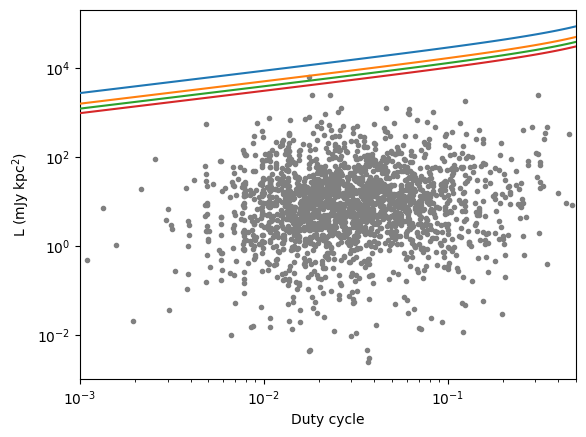

In [58]:
D = 3.6 * u.Mpc

for ti in t:
    S = (sn * Srec / np.sqrt(2 * ti * f) * np.sqrt(dc / (1 - dc))).to(u.Jy)
    L = (S * D**2).to(u.mJy * u.kpc**2)
    plt.plot(dc, L, zorder=3)
    
plt.plot(pulsar_dc, pulsar_lum14, '.', color='gray', zorder=1)

plt.xlabel('Duty cycle')
plt.ylabel('L (mJy kpc$^2$)')
plt.loglog()
plt.xlim(1e-3, 5e-1)

Text(0, 0.5, 'Signed CHORD zenith angle (deg)')

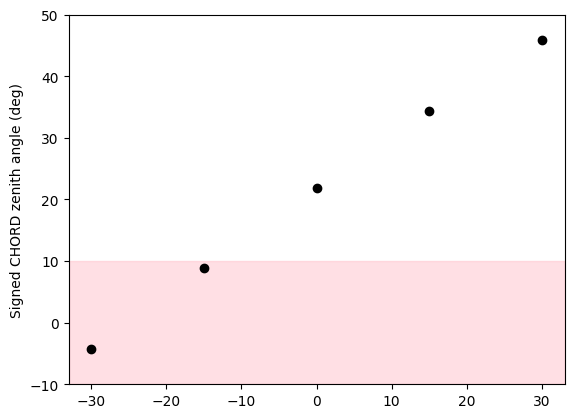

In [60]:
# CHORD + LOFAR observations
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time

source_low_dec = SkyCoord(ra=0*u.deg, dec=50*u.deg)

lofar = EarthLocation.of_site('LOFAR')
chord = EarthLocation.of_site('DRAO')

alt = np.array([90-30, 90-15, 90, 90-15, 90-30]) * u.deg
az = np.array([180, 180, 0, 0, 0]) * u.deg

chord_obs = SkyCoord(alt=alt, az=az, obstime=time, frame='altaz', location=chord)
lofar_obs = chord_obs.transform_to(AltAz(location=lofar))

plt.plot([-30, -15, 0, +15, +30], lofar_obs.alt, "ko")
plt.axhspan(-10, 10, color='pink', alpha=0.5)
plt.ylim([-10, 50])
plt.ylabel('Elevation at LOFAR (deg)')
plt.ylabel('Signed CHORD zenith angle (deg)')

In [56]:
lofar_obs.alt

<Latitude [-4.26934929,  8.83796181, 21.79309588, 34.30310066, 45.84673521] deg>

In [26]:
from astropy import units as u
from astropy.coordinates import Distance
from astropy import constants as const
from astropy.cosmology import Planck18 as cosmo
import numpy as np

def get_snr(
    E = 2.38e41 * u.erg / u.GHz,
    bw = (1500-300) * u.MHz,
    z = 5,
    w = 1 * u.ms, 
    sefd = 10 * u.Jy,
    alpha_spect = -1.39
):
    Dl = cosmo.luminosity_distance(z)
    frb_dist_fact = (4 * np.pi * Dl**2) / (1 + z)**(2+alpha_spect)
    return (    
        E / frb_dist_fact * np.sqrt(2 * bw / w) / sefd
    ).to(u.dimensionless_unscaled)

In [27]:
get_snr(z=10)

<Quantity 11.841767>

In [33]:
chord_z_dist = run_simulation(
    int(1e5),
    telescope_name = 'chord',
    simulate_lensed_frbs = False,
    return_z_dist = True
)

In [38]:
chord_z_dist = np.array(chord_z_dist)

In [55]:
chord_z_dist[chord_z_dist>5].size

23

In [60]:
chord_z_dist[chord_z_dist>2].size / chord_z_dist.size * 100

20.007979253939755

In [36]:
max(chord_z_dist)

8.134208160981576

In [37]:
len(chord_z_dist)

5013

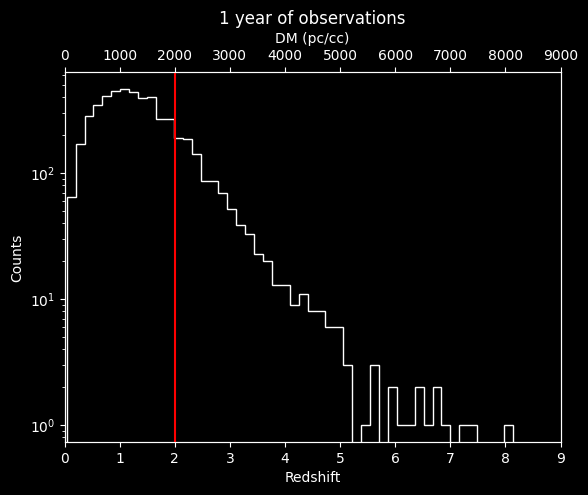

In [61]:
plt.style.use('dark_background')
_ = plt.hist(chord_z_dist, bins=50, log=True, histtype='step', color='w')
plt.xlabel('Redshift')
plt.ylabel('Counts')
plt.xlim(0, 9)
plt.twiny()
plt.xlabel('DM (pc/cc)')
plt.xlim(0, 9000)
plt.title('1 year of observations')

plt.axvline(2000, color='r')

In [ ]:
L_org = M_org.to(u.L_sun)

In [62]:
L = 1e8 * u.L_sun

In [82]:
(1 * u.L_sun).to(u.M_bol)

<Magnitude 4.73999593 mag(Bol)>

In [ ]:
4.7399959 

In [83]:
(10 * u.L_sun).to(u.M_bol)

<Magnitude 2.23999593 mag(Bol)>

In [79]:
(1e8 * u.L_sun).to(u.M_bol).to(u.mag)

UnitConversionError: 'Bol' (power/radiant flux) and '' (dimensionless) are not convertible

In [74]:
(cosmo.distmod(0.2) - (1e8 * u.L_sun).to(u.M_bol)).to(u.dimensionless_unscaled)

UnitConversionError: ("'1 / Bol' and '' (dimensionless) are not convertible", 'Did you perhaps subtract magnitudes so the unit got lost?')

In [71]:
a.unit

Unit("mag")

In [ ]:
# Profile functions

%load_ext line_profiler
%lprun -f get_distribution_E get_distribution_E(number_of_frbs,1e34*u.erg,frb_properties['Echar'],frb_properties['gamma'],)